In [ ]:

#useful libraries
import numpy as np #linear algebra
import math
import pandas as pd #data processing
import matplotlib.pyplot as plt #plotting
import seaborn as sns #visualization


file='2featuresout.csv'
df = pd.read_csv(file)
print(df.describe()) #statistics 

         Unnamed: 0  totaltraveltimeinhours  ...  totalwaitingtime      distance
count  85153.000000            85153.000000  ...      85153.000000  85153.000000
mean   42576.000000                4.272064  ...          0.472406    274.130645
std    24581.698073                2.947939  ...          1.443252    142.227904
min        0.000000                0.120000  ...          0.000000      7.404000
25%    21288.000000                2.320000  ...          0.000000    151.326000
50%    42576.000000                3.740000  ...          0.000000    298.728000
75%    63864.000000                5.440000  ...          0.130000    387.940000
max    85152.000000               25.000000  ...         21.290000    609.816000

[8 rows x 7 columns]


In [ ]:
#check dataset
df

Unnamed: 0  totaltraveltimeinhours  ...  travelfrom  travelto
0               0                    0.39  ...    big_city  big_city
1               1                    0.13  ...    big_city  big_city
2               2                    0.13  ...    big_city  big_city
3               3                    0.39  ...    big_city  big_city
4               4                    0.39  ...    big_city  big_city
...           ...                     ...  ...         ...       ...
85148       85148                    5.17  ...    big_city  big_city
85149       85149                    6.13  ...    big_city  big_city
85150       85150                    4.54  ...    big_city  big_city
85151       85151                    4.54  ...    big_city  big_city
85152       85152                    3.62  ...    big_city  big_city

[85153 rows x 15 columns]

We would NOT reduce the outliers since the DBSCAN is supposed to catch them via -1 cluster, it could properly handle the noise, work with "raw" dataset as it is 85153 rows

In [ ]:
#redundant column via reading
df.drop('Unnamed: 0', axis=1, inplace=True)


In [ ]:
#we do not have missing values, because we use the previous approach with 0s for them for the trial clustering round
df.isna().sum()

totaltraveltimeinhours     0
totalprice                 0
totalnumberofchanges       0
totalwalkingdistance       0
totalwaitingtime           0
objective                  0
finiteautomaton            0
consideredpreferences      0
finalsolutionusedlabels    0
sourcename                 0
targetname                 0
distance                   0
travelfrom                 0
travelto                   0
dtype: int64

In [ ]:

df.drop(df.columns[[5, 9, 10]], axis = 1, inplace = True)#columns to eliminate

Define what columns we need to drop for the clustering
,goal is to cluster the group of trips and see maybe we can detect some new patterns in the data based on clusters

was decided to drop column objective-super low degree of association-0,05.. doesnt have any meaningfull information for clustering,we have completely identical rows with all numerical/categorical variables (having the same labesls) with difference only in objective=> it doesnt change anything, it also repeats somehow the combinations inside the 'considered preferences" column, whoch we will use for clustering

Drop sourcename and targetname for the algorithm- we would need to consider the groups of trips in Germany in general,use the same dropping approach as for kprototypes, ideally in this collab want to use the same data as for kprototypes and outline the differences in groupping

In [ ]:
#the duplicated rows were removed
df.drop_duplicates(keep='last', inplace=True)

In [ ]:
#after dropping check (with all unique values)
df

totaltraveltimeinhours  totalprice  ...  travelfrom  travelto
2                        0.13        2.17  ...    big_city  big_city
3                        0.39        0.86  ...    big_city  big_city
6                        0.13        2.89  ...    big_city  big_city
7                        0.13        2.17  ...    big_city  big_city
8                        0.39        0.86  ...    big_city  big_city
...                       ...         ...  ...         ...       ...
85147                    3.63      106.46  ...    big_city  big_city
85148                    5.17       91.20  ...    big_city  big_city
85149                    6.13       86.04  ...    big_city  big_city
85151                    4.54       22.47  ...    big_city  big_city
85152                    3.62      109.02  ...    big_city  big_city

[30466 rows x 11 columns]

From 85153 to 30466 thousands of rows (mainly because of reducing the objective column)

In [ ]:
#save reduced dataset for KNIME to compare and sharing
from google.colab import files
df.to_csv('cat2featuresout.csv') 
files.download('cat2featuresout.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tried many combinations for dbscan:
only involving numerical data ; numerical + encoded categorical columns the same as for kprototypes; numerical+encoded categorical without travelfromtravelto and with new numerical for population(travelfrom-travelto)

first try here numerical+encoding categorical as we had for kprototypes
use label encoding for the column considered preferences because it has the order => travel time+price < travel time+price+transfers

use label encoding for travelfrom and travelto= we have order-megapolis > big_city>small city

use one hot encoding for finitiautomation (no order) 

In [ ]:
#copy of data for encoding
encoding=df.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder #encode the values
labelencoder = LabelEncoder()

#use label encoding for the column considered preferences because it has the order
encoding['consideredpreferences'] = labelencoder.fit_transform(encoding['consideredpreferences'])#fit label encoder and return encoded labels for the first target column
#use label encoding because we have too many values for one hot encoding for solutionlabels-33 unique combinatios
encoding['finalsolutionusedlabels'] = labelencoder.fit_transform(encoding['finalsolutionusedlabels'])#Fit label encoder and return encoded labels for the second one
#use label encoding since we have order for the city size metropolis>big>small
encoding['travelfrom'] = labelencoder.fit_transform(encoding['travelfrom'])
encoding['travelto'] = labelencoder.fit_transform(encoding['travelto'])

#check encoded data
encoding.head(10)

totaltraveltimeinhours  totalprice  ...  travelfrom  travelto
2                     0.13        2.17  ...           0         0
3                     0.39        0.86  ...           0         0
6                     0.13        2.89  ...           0         0
7                     0.13        2.17  ...           0         0
8                     0.39        0.86  ...           0         0
11                    0.13        2.89  ...           0         0
12                    0.13        2.17  ...           0         0
13                    0.39        0.86  ...           0         0
18                    0.25        3.83  ...           0         0
20                    0.13        2.89  ...           0         0

[10 rows x 11 columns]

In the case of one-hot encoding, for N categories in a variable, it uses N binary variables. The dummy encoding is a small improvement over one-hot-encoding, uses N-1 features to represent N labels/categories.
references are here -
https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

We apply One-Hot Encoding when:The categorical feature has no order,The number of categorical features is less so one-hot encoding can be effectively applied

We apply Label Encoding when: The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school),The number of categories is quite large as one-hot encoding can lead to high memory consumption

In [ ]:
categorical_col= ["finiteautomaton"]
transformed = pd.get_dummies(encoding, columns=categorical_col)#convert categorical target our automation

#check what we have got as the result
transformed.head(10)

totaltraveltimeinhours  ...  finiteautomaton_ptOnly
2                     0.13  ...                       0
3                     0.39  ...                       0
6                     0.13  ...                       1
7                     0.13  ...                       1
8                     0.39  ...                       1
11                    0.13  ...                       0
12                    0.13  ...                       0
13                    0.39  ...                       0
18                    0.25  ...                       0
20                    0.13  ...                       0

[10 rows x 13 columns]

Got our transformed dataset to plug it into dbscan algorithm and check the clusters, use all the features to cluster the observations

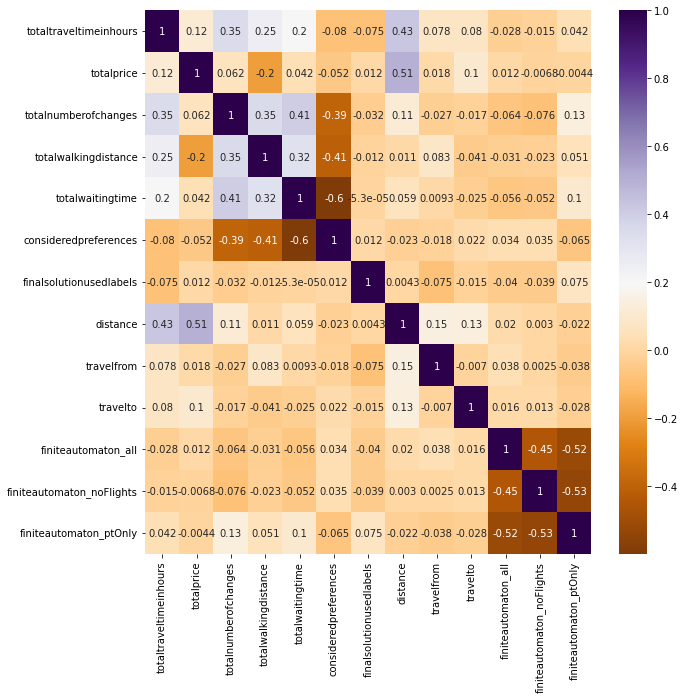

In [ ]:
#create the second correlation matrix using our transformed categorical data plus numerical data
show=transformed.corr(method='kendall')#pairwise correlation
plt.figure(figsize=(10,10))
sns.heatmap(show,annot=True,cmap='PuOr')


reference:https://www.statisticssolutions.com/pearsons-correlation-coefficient/

meaning of correlation number- Perfect: If the value is near ± 1, then it said to be a perfect correlation,High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation.Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation. Low degree: When the value lies below ± 0.29, then it is said to be a small correlation.No correlation: When the value is zero

strong negative correlation between preferences and walking distance&waiting time&transfers=> our minimisation boundaries

new correlation between distance and traveltime(moderate degree) and distance and price(high degree) was revealed, travelfromtravelto-no nice correlation

In [ ]:
#import further libraries for DBscan
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn import metrics # for calculating Silhouette score

import matplotlib.pyplot as plt # for data visualization
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization

from sklearn.cluster import DBSCAN

In [ ]:
# plotting in 3d scatter plot just with the observations before clustering and assigning the groups

fig = px.scatter_3d(transformed, x=transformed['totalprice'], y=transformed['totaltraveltimeinhours'], z=transformed['distance'],
                 opacity=1, color_discrete_sequence=['green'], height=900, width=900)

# update chart looks
fig.update_layout(#title_text="Scatter 3D Plot",
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='blue',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='blue',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='blue', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))

# update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

We would also inolve distance for the graph as 3d axis, as well as transfers (also moderate correlation), will assign the clusters there afterwards, better scattering using for Z distance than transfers (but would try different plots)

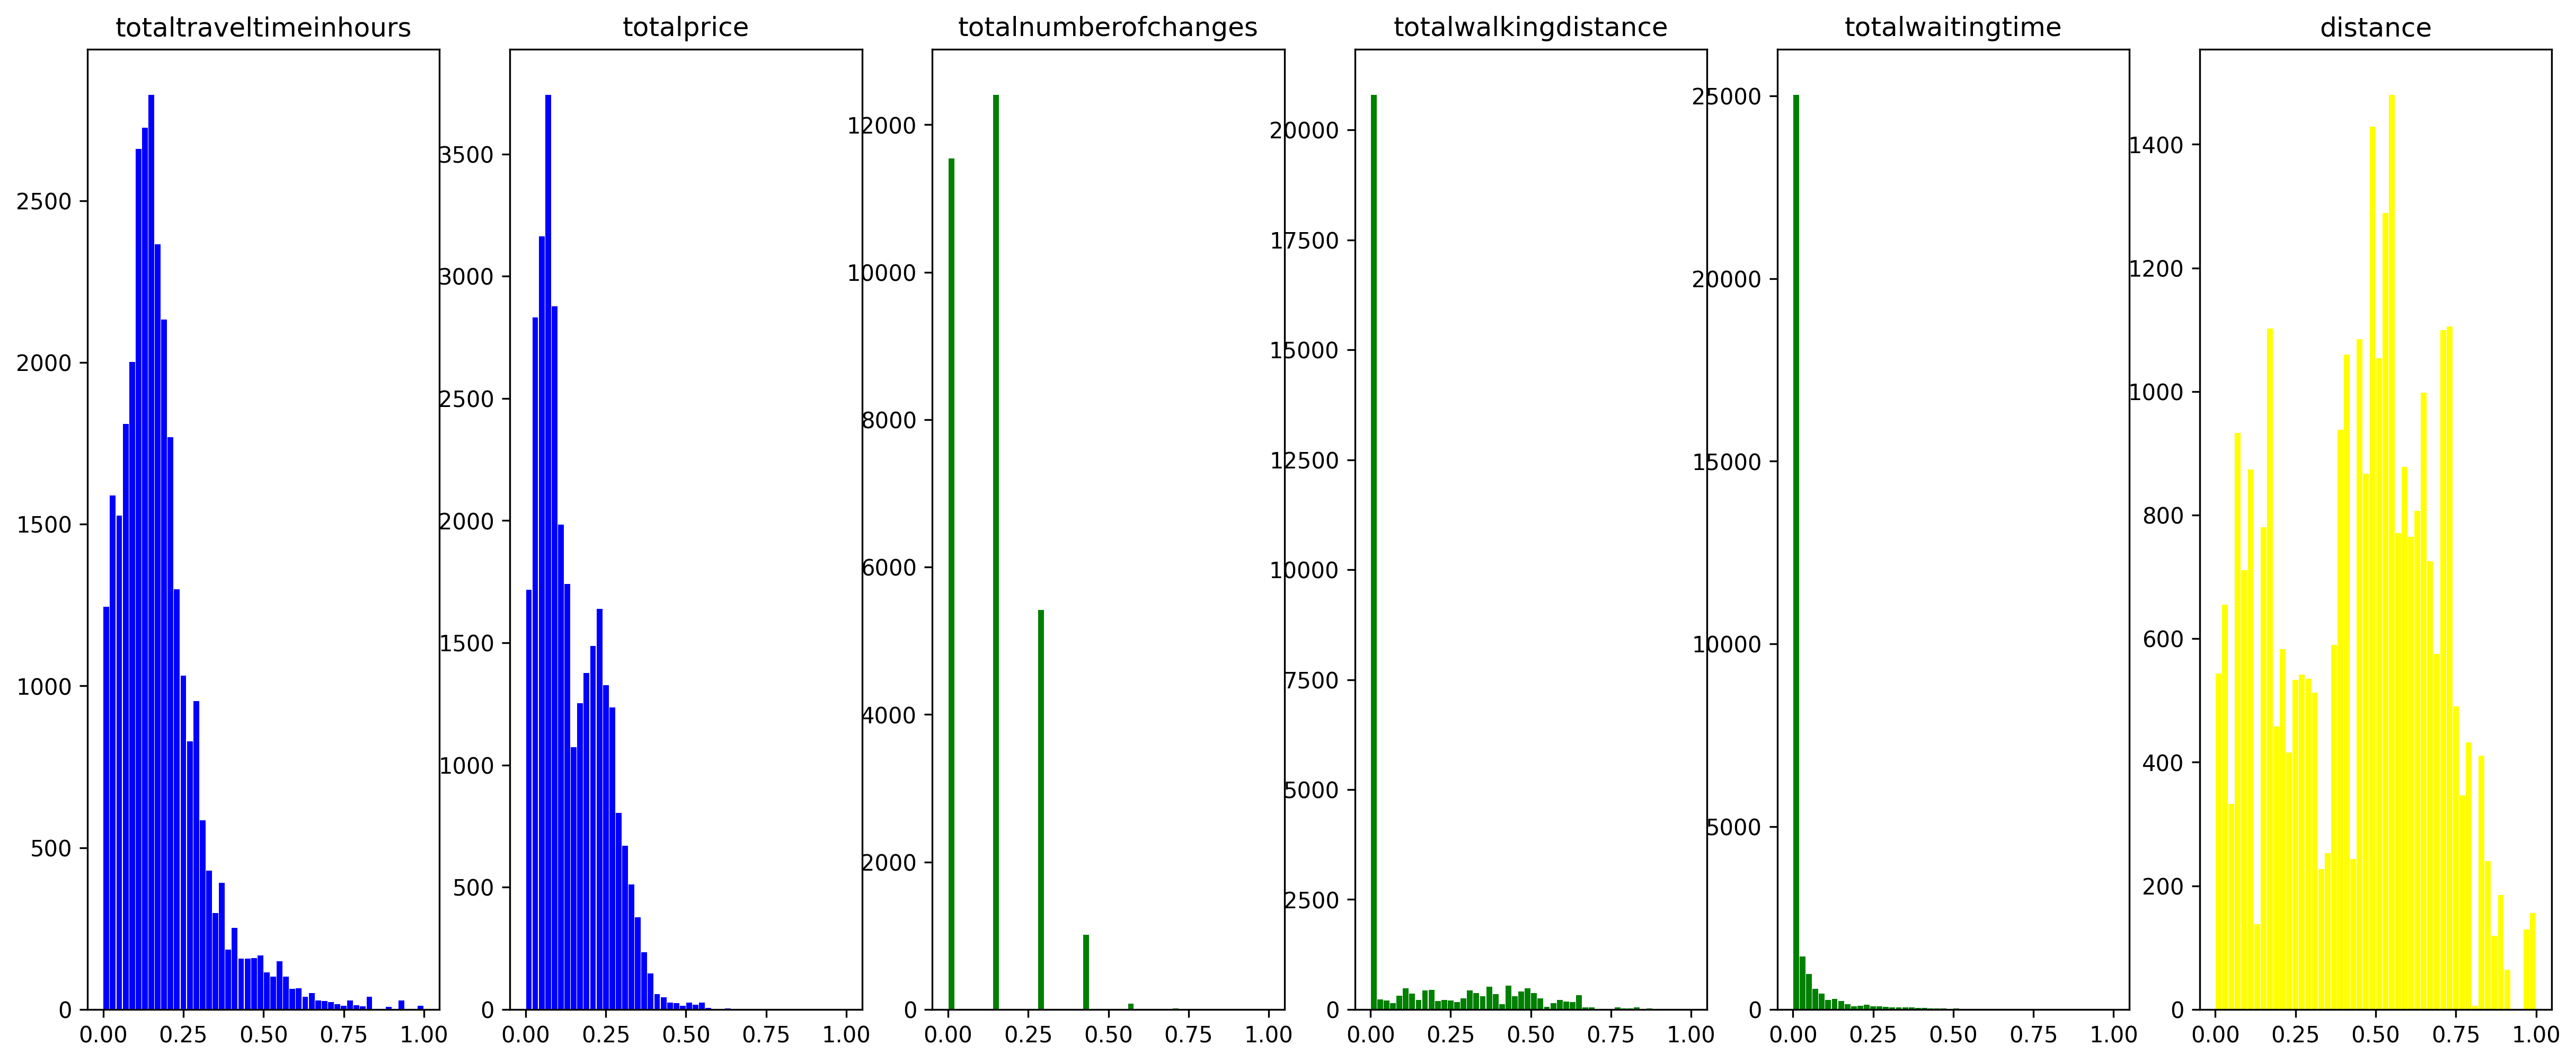

In [ ]:
#apply the scaler
scaler = MinMaxScaler()
transformed_scaled = scaler.fit_transform(transformed)

# plot the min-max scaled distributions (dataset is combined)
#checked that all of them are between 1 and 0, including the newest incorporated feature 'distance'
fig, axs = plt.subplots(1, 6, figsize=(20,8), dpi=300)
axs[0].hist(transformed_scaled[:,0], bins=50, color='blue', rwidth=0.9)
axs[0].set_title('totaltraveltimeinhours')
axs[1].hist(transformed_scaled[:,1], bins=50, color='blue', rwidth=0.9)
axs[1].set_title('totalprice')
axs[2].hist(transformed_scaled[:,2], bins=50, color='green', rwidth=0.9)
axs[2].set_title('totalnumberofchanges')
axs[3].hist(transformed_scaled[:,3], bins=50, color='green', rwidth=0.9)
axs[3].set_title('totalwalkingdistance')
axs[4].hist(transformed_scaled[:,4], bins=50, color='green', rwidth=0.9)
axs[4].set_title('totalwaitingtime')
axs[5].hist(transformed_scaled[:,7], bins=50, color='yellow', rwidth=0.9)
axs[5].set_title('distance')

plt.show()

To scale the features utilized min-max scaler because data distribution is not normal (not fit a gaussian distribution), the same approach for k-prototypes was to use minmaxscaler

In [ ]:
#check the array
transformed_scaled

array([[4.01929260e-04, 4.00530357e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08520900e-02, 3.86718966e-04, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.01929260e-04, 5.99414397e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [2.41559486e-01, 2.35677587e-01, 1.42857143e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.77652733e-01, 6.00795536e-02, 1.42857143e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.40675241e-01, 2.99154743e-01, 1.42857143e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

everything got scaled

In [ ]:
#check the shape
transformed_scaled.shape


(30466, 13)

30466 rows and 13 columns(dimensions), including encoded ones

what minpts to choose: If data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998)=13*2=26, if data is noisy and with duplicates=try even more than 2*dim

In [ ]:
#to elaborate more on epsilon calculate the average distance between each point in the data set and its 26th nearest neighbors ( selected minpts value)

from sklearn.neighbors import NearestNeighbors #use knn approach
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=26) #selected 26minpts. as 13*2=26
neighbors_fit = neighbors.fit(transformed_scaled)
distances, indices = neighbors_fit.kneighbors(transformed_scaled)

references https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

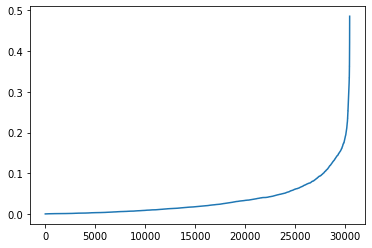

In [ ]:
#sort distance values by ascending value and plot

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Assume that optimal eps would be at the max curvature- 0.08-0.15 - we will try a loop.in general, small values of ε are preferable, and as a rule of thumb, only a small fraction of points should be within this distance of each other.

In [ ]:
#check again with another approach for epsilon

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(transformed_scaled)
distances, indices = nbrs.kneighbors(transformed_scaled)

Calculate the distance from each point to its closest neighbour using the NearestNeighbors, the point itself is included in n_neighbors, the kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points

references https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

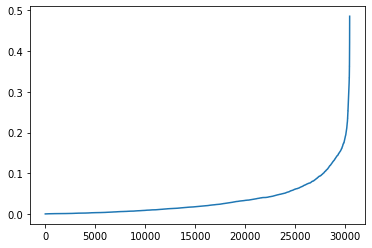

In [ ]:
#sort and plot results 
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Assess again optimal eps should be 0,08-0,15, we will also try a loop with the different combinations to compare Silhouette there and pick the highest one

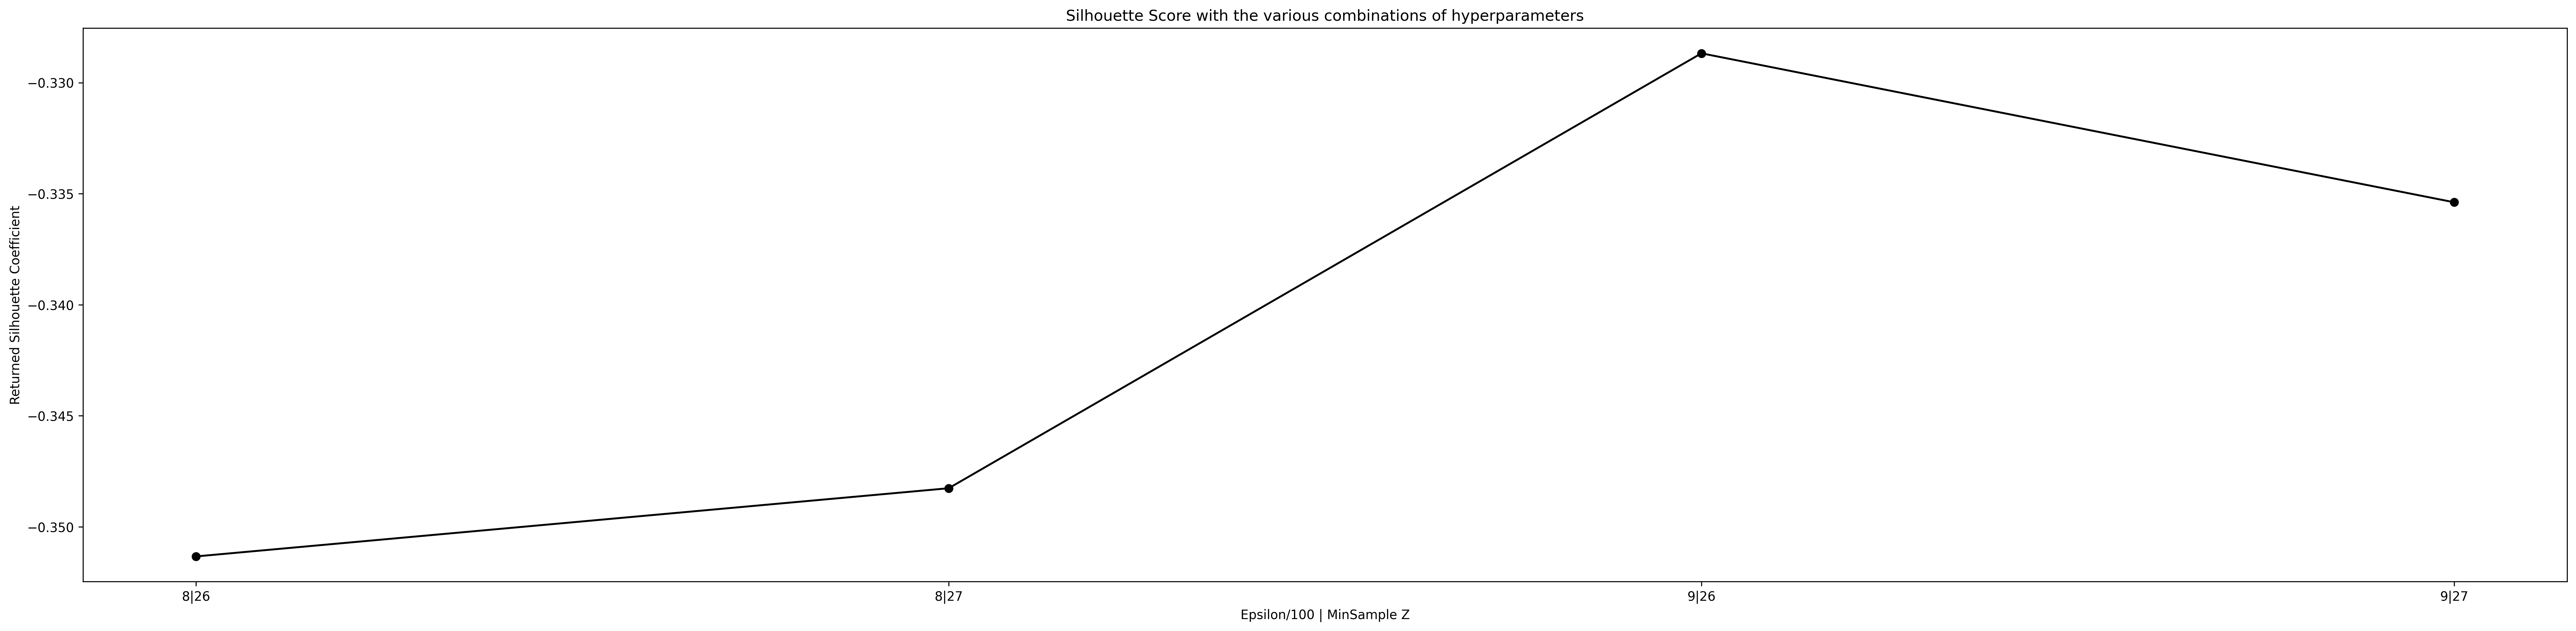

In [ ]:
#test different hyperparameter values for DBscan- the highest Silhouette score -we will use for clustering these parameters
# empty lists

SS=[] # to store inside different Silhouette scores
# to save results of various epsilon and min_samples
combinations=[] 

# ranges to choose
# we will choose different suitables ranges to test
eps_range=range(8,10) # 0.08 - 0,1 range

minpts_range=range(26,28) #rule of thumb-choose based on number of dimensions (dim+1 as min), or even more dim*2

for k in eps_range:
    for j in minpts_range:
        # model and parameters
        model = DBSCAN(eps=k/100, min_samples=j)
        # fitting the model 
        clm = model.fit(transformed_scaled)
        # calculation of Silhoutte Score and appending it to the list
        SS.append(metrics.silhouette_score(transformed_scaled, clm.labels_, metric='euclidean'))
        combinations.append(str(k)+"|"+str(j)) # axis values for the graph

# plotting the results of Silhouette scores to make a decision
plt.figure(figsize=(35,8), dpi=300)
plt.plot(combinations, SS, 'bo-', color='black')
plt.xlabel('Epsilon/100 | MinSample Z')
plt.ylabel('Returned Silhouette Coefficient')
plt.title('Silhouette Score with the various combinations of hyperparameters')
plt.show()


Running time is 1 minute, we can conclude that with the canonical parameters in accordance to a rule of Thumb the Silhouette would be even below 0 (negative)

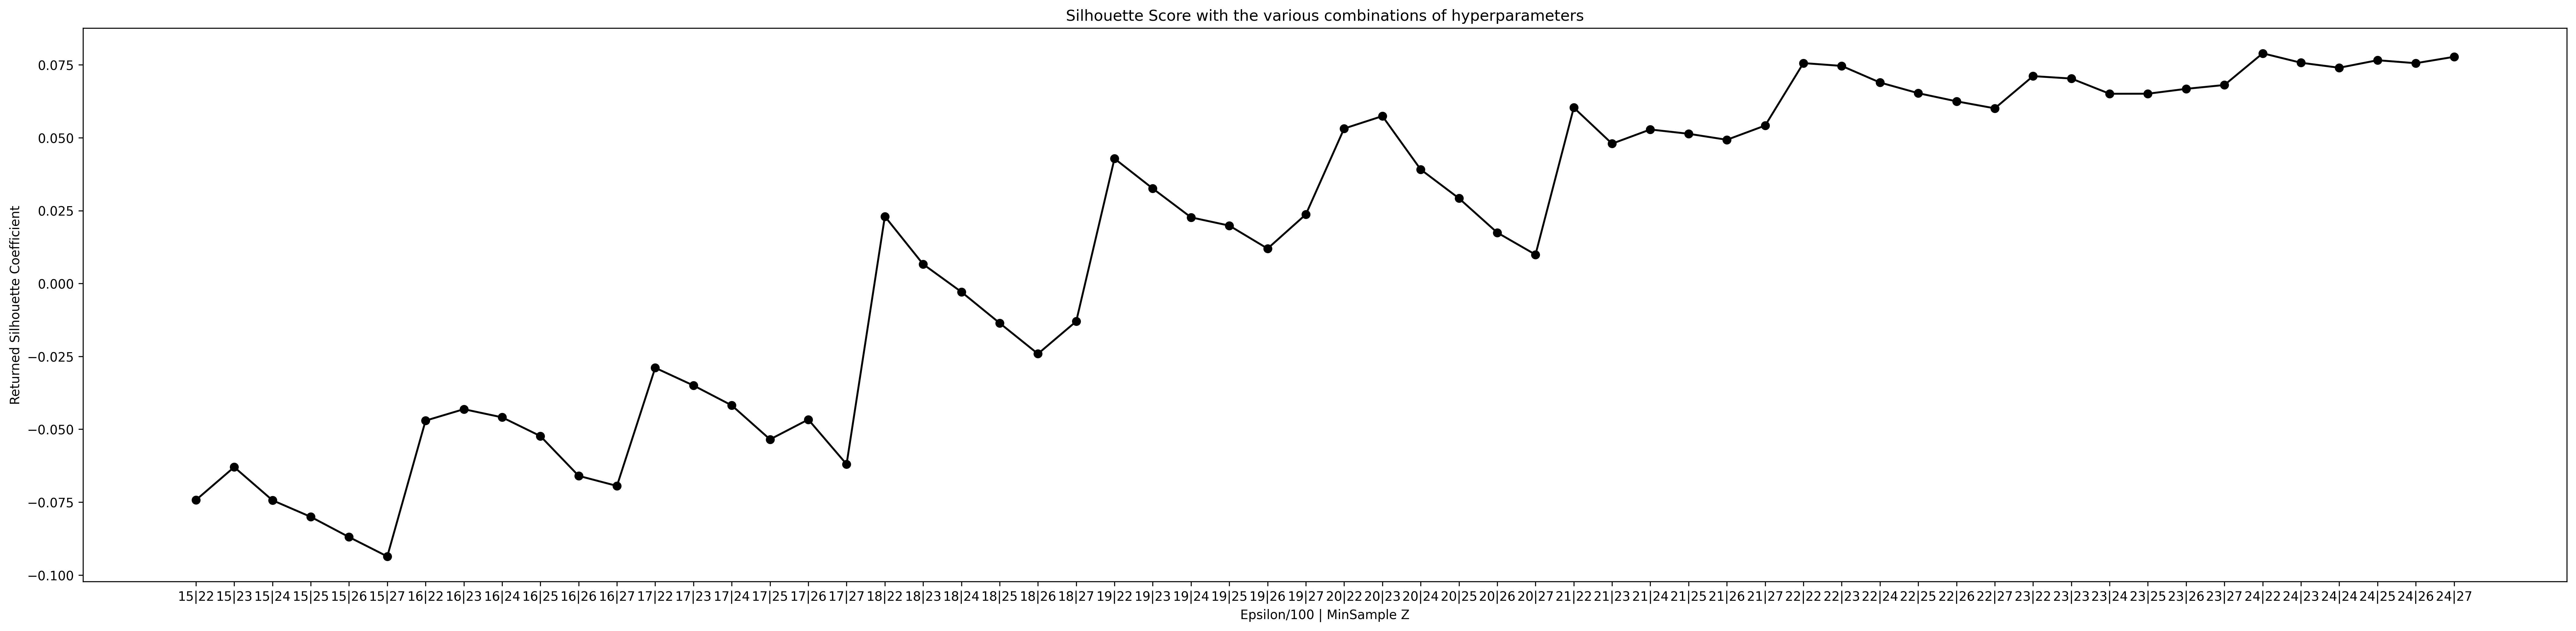

In [ ]:
#test different hyperparameter values for DBscan- the highest Silhouette score -we will use for clustering these parameters
# empty lists

SS=[] # to store inside different Silhouette scores
# to save results of various epsilon and min_samples
combinations=[] 

# ranges to choose
# we will choose different suitables ranges to test
eps_range=range(15,25) # 0.15 - 0,25 range

minpts_range=range(22,28) #rule of thumb-choose based on number of dimensions (dim+1 as min), or even more dim*2

for k in eps_range:
    for j in minpts_range:
        # model and parameters
        model = DBSCAN(eps=k/100, min_samples=j)
        # fitting the model 
        clm = model.fit(transformed_scaled)
        # calculation of Silhoutte Score and appending it to the list
        SS.append(metrics.silhouette_score(transformed_scaled, clm.labels_, metric='euclidean'))
        combinations.append(str(k)+"|"+str(j)) # axis values for the graph

# plotting the results of Silhouette scores to make a decision
plt.figure(figsize=(35,8), dpi=300)
plt.plot(combinations, SS, 'bo-', color='black')
plt.xlabel('Epsilon/100 | MinSample Z')
plt.ylabel('Returned Silhouette Coefficient')
plt.title('Silhouette Score with the various combinations of hyperparameters')
plt.show()


Running time is 20+ minutes, we can conclude that the highest Silhouette is really low -0,075 clusters are indifferent

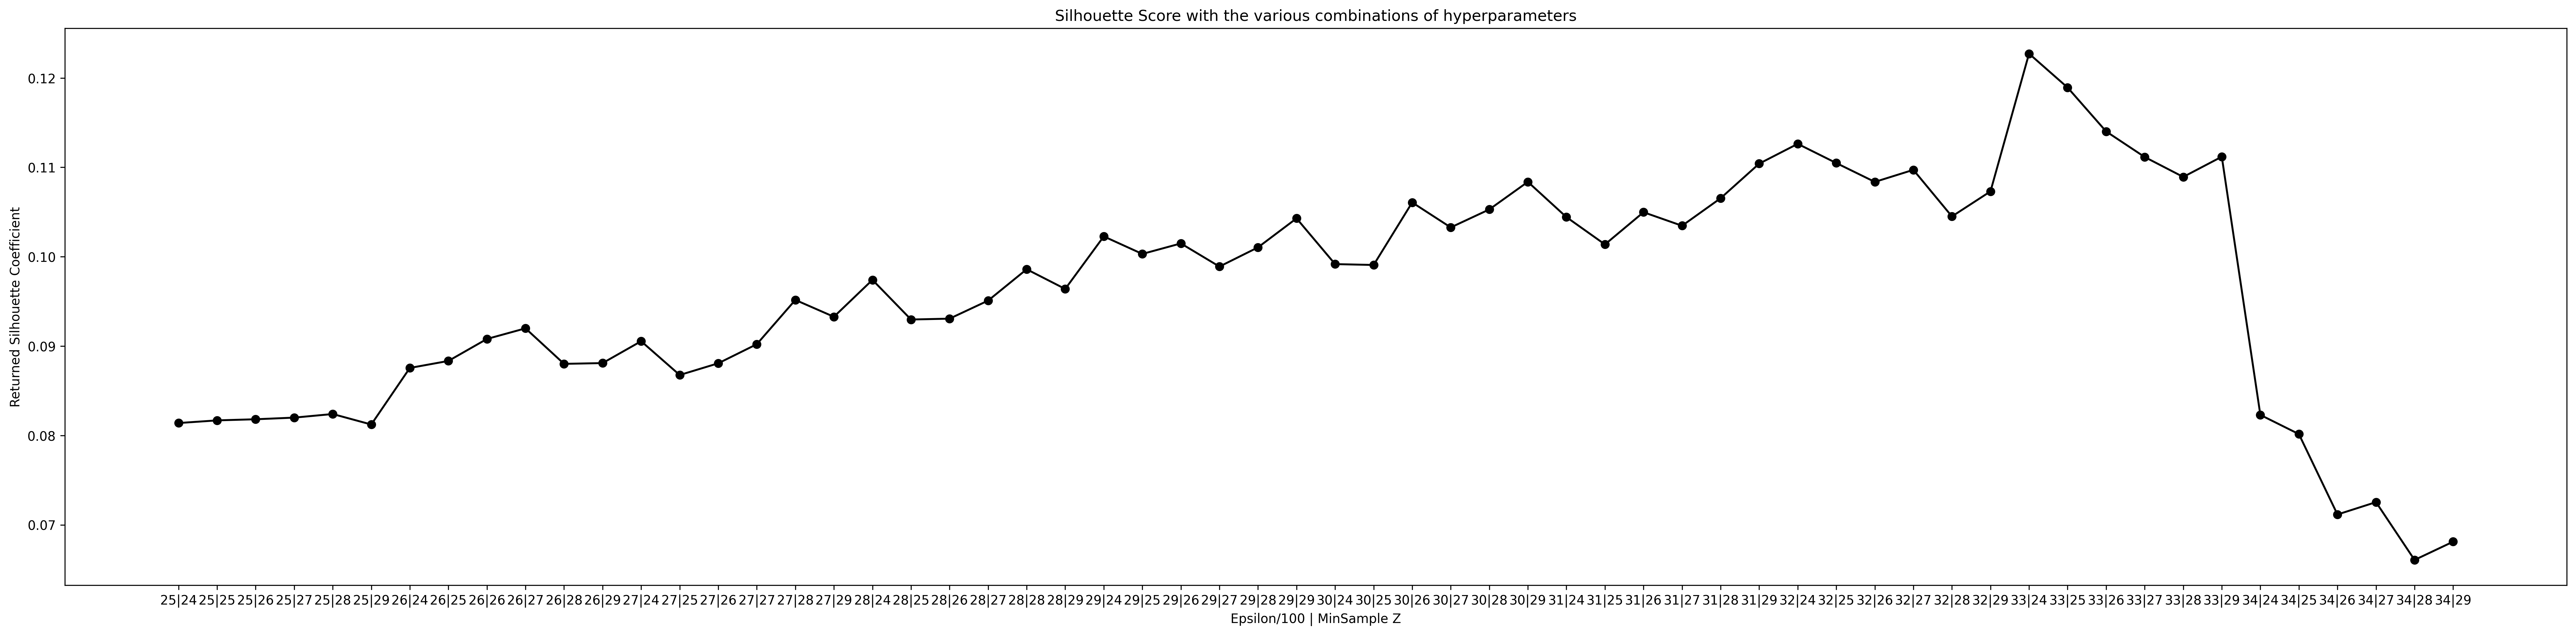

In [ ]:
#test different hyperparameter values for DBscan- the highest Silhouette score -we will use for clustering these parameters
# empty lists

SS=[] # to store inside different Silhouette scores
# to save results of various epsilon and min_samples
combinations=[] 

# ranges to choose
# we will choose different suitables ranges to test
eps_range=range(25,35) # 0.25 - 0,35 range

minpts_range=range(25,30) #rule of thumb-choose based on number of dimensions (dim+1 as min), or even more dim*2, would test more

for k in eps_range:
    for j in minpts_range:
        # model and parameters
        model = DBSCAN(eps=k/100, min_samples=j)
        # fitting the model 
        clm = model.fit(transformed_scaled)
        # calculation of Silhoutte Score and appending it to the list
        SS.append(metrics.silhouette_score(transformed_scaled, clm.labels_, metric='euclidean'))
        combinations.append(str(k)+"|"+str(j)) # axis values for the graph

# plotting the results of Silhouette scores to make a decision
plt.figure(figsize=(35,8), dpi=300)
plt.plot(combinations, SS, 'bo-', color='black')
plt.xlabel('Epsilon/100 | MinSample Z')
plt.ylabel('Returned Silhouette Coefficient')
plt.title('Silhouette Score with the various combinations of hyperparameters')
plt.show()


Running time is 25+ minutes, we can conclude that the highest Silhouette is really low -0,12 clusters are indifferent

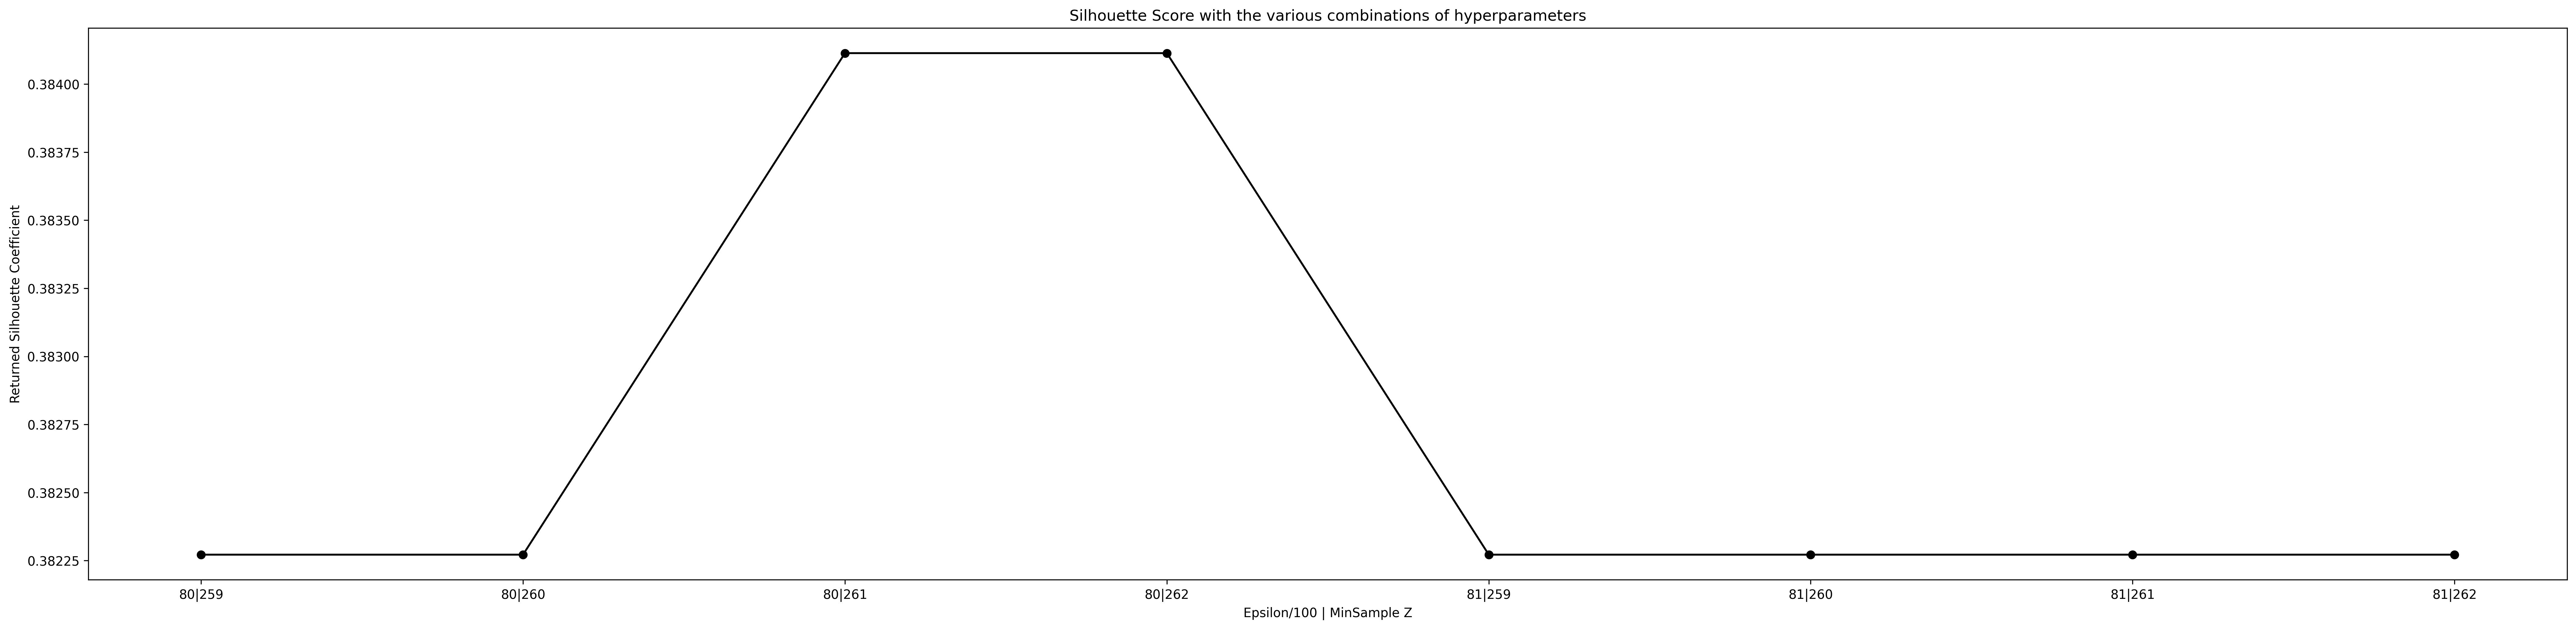

In [ ]:
#test different approach for hyperparameter values for DBscan- the highest Silhouette score -we will use for clustering these parameters

# empty lists

SS=[] # to store inside different Silhouette scores
# to save results of various epsilon and min_samples
combinations=[] 

# ranges to choose
# we will choose different suitables ranges to test
eps_range=range(80,82) # 0.08 - 0,16 range

minpts_range=range(259,263) #rule of thumb-choose based on number of dimensions (dim+1 as min), or even more dim*2

for k in eps_range:
    for j in minpts_range:
        # model and parameters
        model = DBSCAN(eps=k/100, min_samples=j)
        # fitting the model 
        clm = model.fit(transformed_scaled)
        # calculation of Silhoutte Score and appending it to the list
        SS.append(metrics.silhouette_score(transformed_scaled, clm.labels_, metric='euclidean'))
        combinations.append(str(k)+"|"+str(j)) # axis values for the graph

# plotting the results of Silhouette scores to make a decision
plt.figure(figsize=(35,8), dpi=300)
plt.plot(combinations, SS, 'bo-', color='black')
plt.xlabel('Epsilon/100 | MinSample Z')
plt.ylabel('Returned Silhouette Coefficient')
plt.title('Silhouette Score with the various combinations of hyperparameters')
plt.show()


An approach-multiply eps*10=0.8 instead of 0.08 and 260 for minpts instead of 26 (if we have noise or duplicates we can use really big number for minpts)

Running time is 3 minutes, we can conclude that epsilon 0,8 and 261 minpts produce the highest silhouette score 0,384 from the combinations, but still the score is not ideal

In [ ]:
#eventually use for the model: eps=0.8, MinPts=261

modeldb = DBSCAN(eps=0.8, # default=0.5
               min_samples=261, # default=5, the number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
               metric='euclidean', # default='euclidean'. the metric to use when calculating distance between instances in a feature array. 
               metric_params=None, # default=None, additional keyword arguments for the metric function.
               algorithm='auto', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’, the algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
               leaf_size=30, # default=30, 
               p=None, # default=None, the power of the Minkowski metric to be used to calculate distance between points. If None, then p=2
               n_jobs=None, # default=None, the number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
              )



# fit our model
clustm = modeldb.fit(transformed_scaled)


# check the results we got
print('DBSCAN Clustering Model ')
print("Cluster labels for the first model")
print(clustm.labels_)


DBSCAN Clustering Model 
Cluster labels for the first model
[0 0 1 ... 1 2 2]


7 clusters were formed, including -1 means that we alghorithm detected noise points, would be 6 groups in total

In [ ]:
#assign clusters to the data frame for further analysis of groups via plots for investigations and finding the patterns
df['DBSCAN cluster']=clustm.labels_
df

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
55830                    3.97      119.68  ...  metropolis               0
78355                    3.16       84.93  ...    big_city               0
2001                     0.86        6.08  ...    big_city               1
72992                    4.42       48.05  ...    big_city               1
47941                    4.38      131.68  ...    big_city               1
...                       ...         ...  ...         ...             ...
37568                    5.09       20.23  ...    big_city               1
8972                    13.76       25.13  ...    big_city               1
56775                    4.05       20.24  ...    big_city               1
74450                   10.57       33.99  ...    big_city               2
51512                    1.82       34.26  ...    big_city               2

[30466 rows x 12 columns]

In [ ]:
a = df['DBSCAN cluster'].unique() #check the groups
a

array([ 0,  1,  2,  3,  4,  5, -1])

In [ ]:
# plot the clusters in 3d environment with the colors assigned per cluster with the third one as the distance
df=df.sort_values(by=['DBSCAN cluster'])

# 3d scatter plot
fig = px.scatter_3d(df, x=df['totalprice'], y=df['totaltraveltimeinhours'], z=df['distance'], 
                    opacity=1, color=df['DBSCAN cluster'].astype(str), 
                    color_discrete_sequence=['black']+px.colors.qualitative.Plotly,
                    hover_data=['totalwalkingdistance', 'totalwaitingtime'],
                    width=900, height=900
                   )

# chart
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=0.04, xanchor="left", x=0.1),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# change marker size
fig.update_traces(marker=dict(size=2))

fig.show()



With the silhouette 0,384 we can conclude that clusters are indifferent since the distance between them is not really significant, harder to evaluate on 3d graph, better to use 2 dimensions

In [ ]:
# plot the clusters in 3d environment with the colors assigned per cluster with the 3d one as the number of changes
df=df.sort_values(by=['DBSCAN cluster'])

# 3d scatter plot
fig = px.scatter_3d(df, x=df['totalprice'], y=df['totaltraveltimeinhours'], z=df['totalnumberofchanges'], #use another column as a third one
                    opacity=1, color=df['DBSCAN cluster'].astype(str), 
                    color_discrete_sequence=['black']+px.colors.qualitative.Plotly,
                    hover_data=['totalwalkingdistance', 'totalwaitingtime'],
                    width=900, height=900
                   )

# chart
fig.update_layout(#title_text="Scatter 3D Plot",
                  showlegend=True,
                  legend=dict(orientation="h", yanchor="bottom", y=0.04, xanchor="left", x=0.1),
                  scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                        center=dict(x=0, y=0, z=-0.2),
                                        eye=dict(x=1.5, y=1.5, z=0.5)),
                                        margin=dict(l=0, r=0, b=0, t=0),
                  scene = dict(xaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         ),
                               yaxis=dict(backgroundcolor='white',
                                          color='black',
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                          ),
                               zaxis=dict(backgroundcolor='lightgrey',
                                          color='black', 
                                          gridcolor='#f0f0f0',
                                          title_font=dict(size=10),
                                          tickfont=dict(size=10),
                                         )))
# change marker size
fig.update_traces(marker=dict(size=2))

fig.show()


With the silhouette 0,384 we can conclude that clusters are indifferent since the distance between them is not really significant, harder to evaluate on 3d graph, better to use 2 dimensions

In [ ]:
#check how many instances belong to the cluster
print(pd.Series(clustm.labels_).value_counts())


 1    9992
 2    8073
 0    7558
 3    1660
 4    1641
 5    1540
-1       2
dtype: int64


Only 2 points were detected as the noise from the alghorithm, the biggest group is the 1st one

In [ ]:
df['DBSCAN cluster']=clustm.labels_ #attach the labels per new column

In [ ]:
#0,1,2,3,4,5,6 our 6 groups (excluding -1)
labels=clustm.labels_
labels

array([0, 0, 1, ..., 1, 2, 2])

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1) #-1 group is a noise group

In [ ]:
print("Estimated number of clusters: %d" % n_clusters_) #printing the estimations
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 6
Estimated number of noise points: 2


In [ ]:
#to plot in 2 dimensions
dbscan=DBSCAN(eps=0.8, min_samples=261)

In [ ]:
lables=dbscan.fit_predict(transformed_scaled)

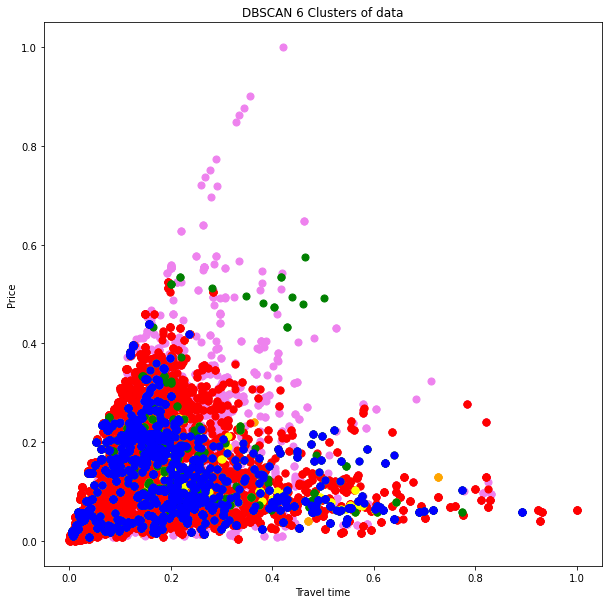

In [ ]:
#2 dimensions- 6 clusters
lables=dbscan.fit_predict(transformed_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(transformed_scaled[lables == -1, 0], transformed_scaled[lables == -1, 1], s = 50, c = 'black') #assign the colors
plt.scatter(transformed_scaled[lables == 0, 0], transformed_scaled[lables == 0, 1], s = 50, c = 'orange')
plt.scatter(transformed_scaled[lables == 1, 0], transformed_scaled[lables == 1, 1], s = 50, c = 'violet')
plt.scatter(transformed_scaled[lables == 2, 0], transformed_scaled[lables == 2, 1], s = 50, c = 'red')
plt.scatter(transformed_scaled[lables == 3, 0], transformed_scaled[lables == 3, 1], s = 50, c = 'yellow')
plt.scatter(transformed_scaled[lables == 4, 0], transformed_scaled[lables == 4, 1], s = 50, c = 'green')
plt.scatter(transformed_scaled[lables == 5, 0], transformed_scaled[lables == 5, 1], s = 50, c = 'blue')

plt.xlabel('Travel time')
plt.ylabel('Price')
plt.title('DBSCAN 6 Clusters of data')
plt.show()

pink group is the most expensive one, red is the highest per travelling time (also dark blue is high)

clusters are a bit shuffled (Silhouette is not extremely strong)

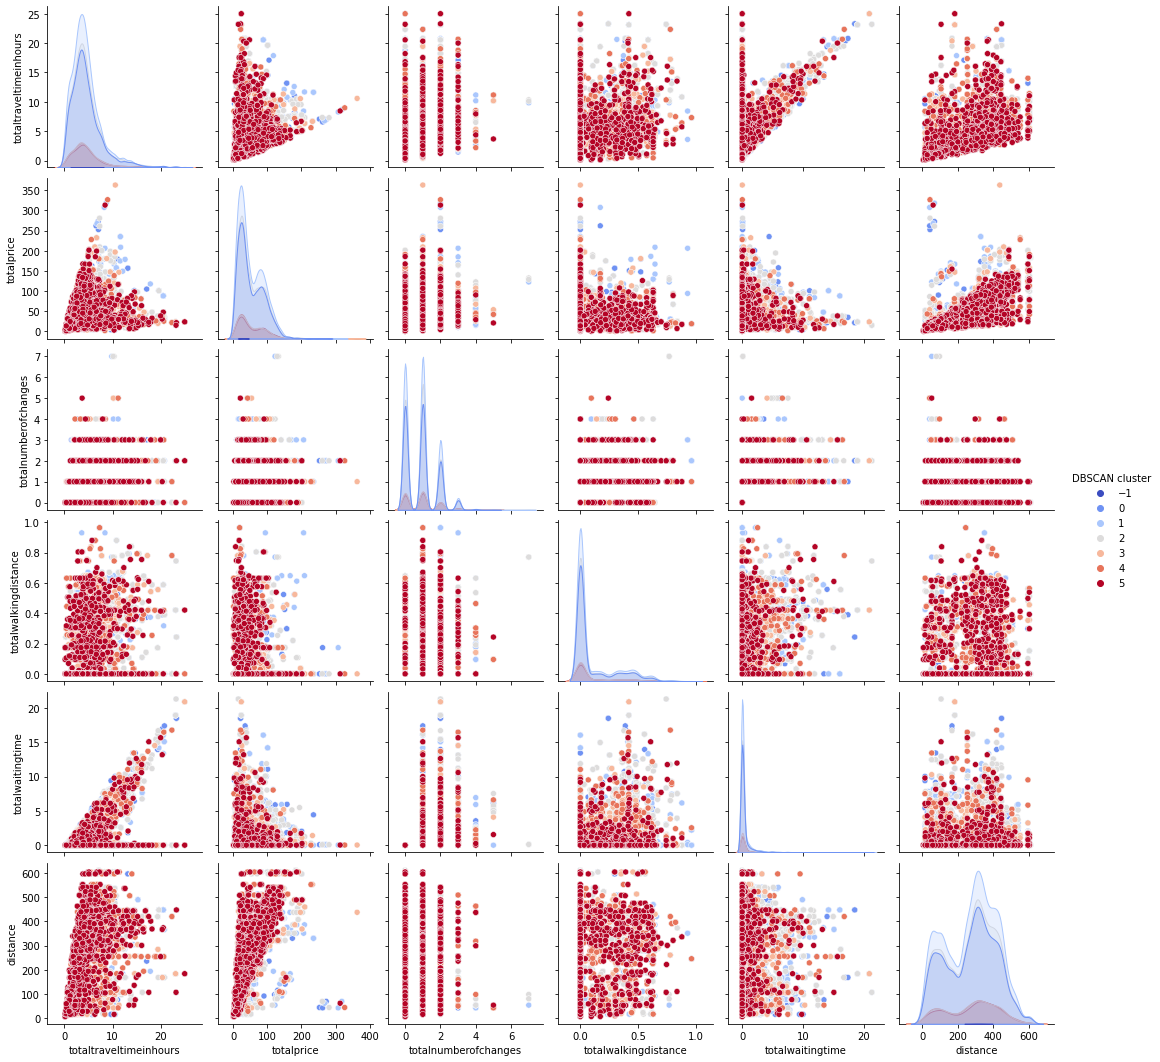

In [ ]:
#pairwise clusters unscaled
sns.pairplot(df,vars=['totaltraveltimeinhours','totalprice','totalnumberofchanges','totalwalkingdistance', 'totalwaitingtime', 'distance'],hue='DBSCAN cluster', palette ='coolwarm')

In [ ]:
#6 unique clusters + noise group
np.unique(lables)

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
#form the group for cluster 1 with index of 0
cluster_1= df[df['DBSCAN cluster']== 0]
cluster_1.head(15) #get the results

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
71327                    4.25       35.31  ...    big_city               0
77769                    3.62       89.97  ...    big_city               0
3767                     1.23       50.36  ...    big_city               0
85017                    7.87       17.59  ...    big_city               0
3638                     3.58       11.63  ...    big_city               0
46144                    1.50       43.24  ...    big_city               0
20300                    3.82      167.36  ...  metropolis               0
64713                    5.18       88.22  ...    big_city               0
12830                    2.13       92.14  ...    big_city               0
70855                    5.54       25.81  ...  small_city               0
27918                    6.47       91.94  ...    big_city               0
31563                    1.83       28.85  ...    big_city               0
64919                    5.57       98.32  ...    big_city               0
32077                    4.14      101.61  ...    big_city               0
22770                    2.84       72.27  ...    big_city               0

[15 rows x 12 columns]

mixed results

In [ ]:
#form the group for cluster 2 with index 1
cluster_2= df[df['DBSCAN cluster']== 1]
cluster_2.head(15) #get the results

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
15478                   10.06       29.22  ...    big_city               1
67996                    5.67       21.78  ...    big_city               1
24793                   18.78       25.51  ...    big_city               1
74733                    0.93       16.41  ...    big_city               1
28191                    2.63       87.41  ...  metropolis               1
50863                    2.26       19.30  ...    big_city               1
71292                    4.25       35.31  ...    big_city               1
84885                    2.43       60.03  ...    big_city               1
5345                     1.97       68.18  ...    big_city               1
2414                     4.88       97.47  ...    big_city               1
72379                    2.75      100.68  ...    big_city               1
54119                    6.85       35.08  ...    big_city               1
4312                     5.00       36.99  ...    big_city               1
69941                    2.58       36.64  ...    big_city               1
77746                    3.62       89.97  ...    big_city               1

[15 rows x 12 columns]

In [ ]:
#form the group for cluster 3 with index of 2
cluster_3= df[df['DBSCAN cluster']== 2]
cluster_3.head(15) #get the results

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
74956                    3.03       67.02  ...    big_city               2
65737                    4.43       41.56  ...    big_city               2
18650                    4.28       24.93  ...    big_city               2
9590                     1.32       58.07  ...    big_city               2
69583                    3.87       60.36  ...    big_city               2
81716                    5.56       71.11  ...    big_city               2
41357                    4.39       32.83  ...    big_city               2
55944                    3.97      119.68  ...  metropolis               2
52298                   11.57       31.00  ...    big_city               2
48211                    5.40      114.17  ...    big_city               2
64029                    3.63      108.43  ...    big_city               2
72863                    4.96       33.17  ...    big_city               2
66229                    3.38       67.67  ...    big_city               2
64387                    5.62      119.11  ...    big_city               2
43598                   11.28      117.10  ...    big_city               2

[15 rows x 12 columns]

In [ ]:
#form the group for cluster 4
cluster_4= df[df['DBSCAN cluster']== 3]
cluster_4.head(15) #get the results

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
5319                     1.97       68.18  ...    big_city               3
36176                    2.67       65.04  ...    big_city               3
58510                    1.11        7.57  ...    big_city               3
13750                    6.68       31.93  ...    big_city               3
10185                   17.95       23.36  ...    big_city               3
62334                    7.41       32.22  ...    big_city               3
29623                    3.72       83.21  ...    big_city               3
69043                    5.82       61.94  ...    big_city               3
28475                    0.32        5.26  ...    big_city               3
837                      3.16       59.91  ...  metropolis               3
66735                    3.42       54.72  ...    big_city               3
4680                     3.48       32.83  ...    big_city               3
51515                    1.65       40.44  ...    big_city               3
41353                    2.75      109.14  ...    big_city               3
64072                    4.08      103.64  ...    big_city               3

[15 rows x 12 columns]

In [ ]:
#form the group for cluster 5
cluster_5= df[df['DBSCAN cluster']== 4]
cluster_5.head(15) #get the results

totaltraveltimeinhours  totalprice  ...  travelto  DBSCAN cluster
81182                    9.40       38.94  ...  big_city               4
64391                    3.83      139.49  ...  big_city               4
63316                    4.58       33.99  ...  big_city               4
8716                     2.40       65.79  ...  big_city               4
68927                    4.58      121.82  ...  big_city               4
49677                    5.78       21.71  ...  big_city               4
42304                    3.54       20.12  ...  big_city               4
1398                     7.03       26.00  ...  big_city               4
59011                    1.23       22.71  ...  big_city               4
75327                    1.96        6.47  ...  big_city               4
21357                    3.07       39.85  ...  big_city               4
83550                    5.18       31.07  ...  big_city               4
22230                    0.57       11.13  ...  big_city               4
22904                    5.58      111.89  ...  big_city               4
69840                    3.27       70.41  ...  big_city               4

[15 rows x 12 columns]

In [ ]:
#form the group for cluster 6
cluster_6= df[df['DBSCAN cluster']== 5]
cluster_6.head(15) #get the results

totaltraveltimeinhours  totalprice  ...    travelto  DBSCAN cluster
11597                    0.27        8.30  ...    big_city               5
77706                    7.32       37.42  ...    big_city               5
5037                     5.73       14.23  ...    big_city               5
68247                    4.13      108.65  ...    big_city               5
80186                    5.40      101.29  ...    big_city               5
16366                   16.48       23.44  ...    big_city               5
47948                    6.38       44.86  ...    big_city               5
77178                    7.33       40.01  ...  metropolis               5
40733                    0.62       14.34  ...    big_city               5
3524                     1.30       29.70  ...    big_city               5
77904                    2.72       12.74  ...    big_city               5
73020                    3.88       48.66  ...    big_city               5
20299                    3.83      167.36  ...  metropolis               5
9760                     5.60       50.16  ...    big_city               5
67620                    3.27       37.24  ...    big_city               5

[15 rows x 12 columns]

In [ ]:
#for the distance min almost the same except 4th group
def minvalue(data):
  minvalue = data[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice', 'distance']].min()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance': ")
  print(minvalue)

minvalue(cluster_1)
minvalue(cluster_2)
minvalue(cluster_3)
minvalue(cluster_4)
minvalue(cluster_5)
minvalue(cluster_6)


minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance': 
totaltraveltimeinhours    0.120
totalwaitingtime          0.000
totalnumberofchanges      0.000
totalwalkingdistance      0.000
totalprice                0.720
distance                  7.404
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance': 
totaltraveltimeinhours    0.120
totalwaitingtime          0.000
totalnumberofchanges      0.000
totalwalkingdistance      0.000
totalprice                0.720
distance                  7.404
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance': 
totaltraveltimeinhours    0.120
totalwaitingtime          0.000
totalnumberofchanges      0.000
totalwalkingdistance      0.000
totalprice       

In [ ]:
#investigate the group with respect to max value
def maxvalue(d):
  maxvalue = d[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice', 'distance']].max()
  print("maximum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : ")
  print(maxvalue)

maxvalue(cluster_1)
maxvalue(cluster_2)
maxvalue(cluster_3)
maxvalue(cluster_4)
maxvalue(cluster_5)
maxvalue(cluster_6)


maximum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours     25.000
totalwaitingtime           20.880
totalnumberofchanges        5.000
totalwalkingdistance        0.965
totalprice                272.350
distance                  609.816
dtype: float64
maximum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours     25.000
totalwaitingtime           21.290
totalnumberofchanges        7.000
totalwalkingdistance        0.965
totalprice                318.010
distance                  609.816
dtype: float64
maximum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours     25.000
totalwaitingtime           21.290
totalnumberofchanges        7.000
totalwalkingdist

no interesting or exclusive pattern

In [ ]:
#investigate the group wrt mean value

#no distinctive mean
def meanvalue(dat):
  meanvalue = dat[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice', 'distance']].mean()
  print("mean value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : ")
  print(meanvalue)

meanvalue(cluster_1)
meanvalue(cluster_2)
meanvalue(cluster_3)
meanvalue(cluster_4)
meanvalue(cluster_5)
meanvalue(cluster_6)


mean value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours      4.506291
totalwaitingtime            0.463515
totalnumberofchanges        0.875099
totalwalkingdistance        0.104337
totalprice                 51.196160
distance                  274.968358
dtype: float64
mean value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours      4.472633
totalwaitingtime            0.467071
totalnumberofchanges        0.870897
totalwalkingdistance        0.110196
totalprice                 51.008038
distance                  275.936896
dtype: float64
mean value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice' & 'distance' : 
totaltraveltimeinhours      4.520216
totalwaitingtime            0.499988
totalnumberofchan

Values in general- the mean is almost the same for the groups

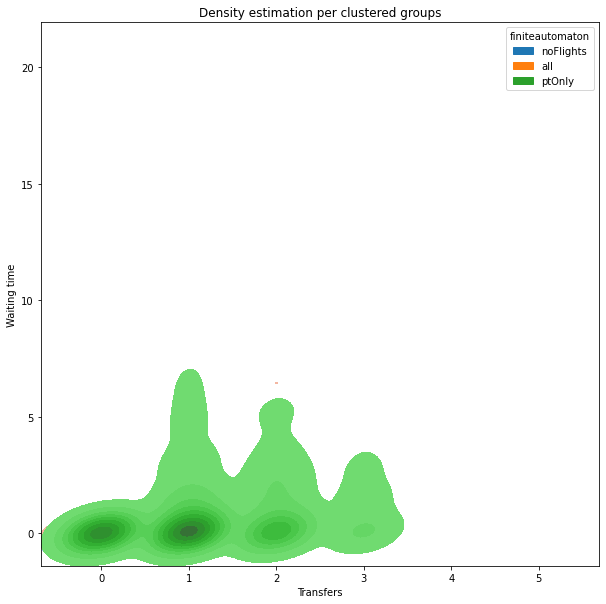

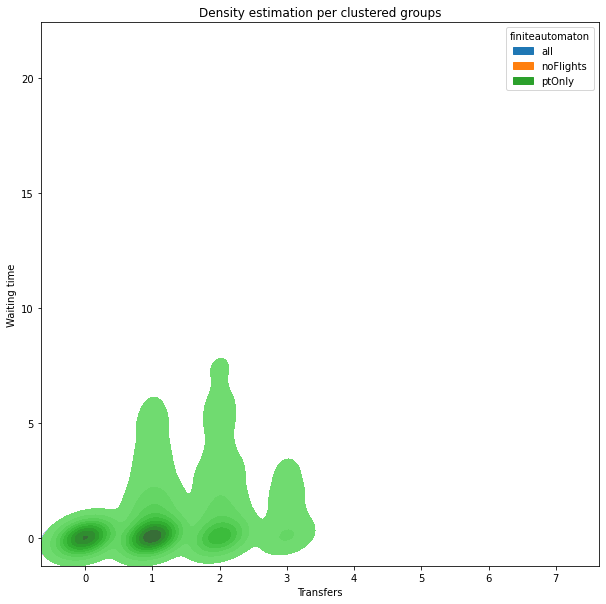

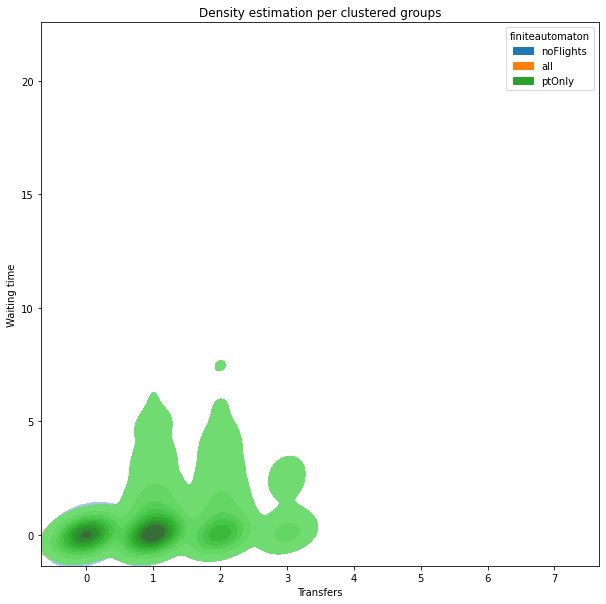

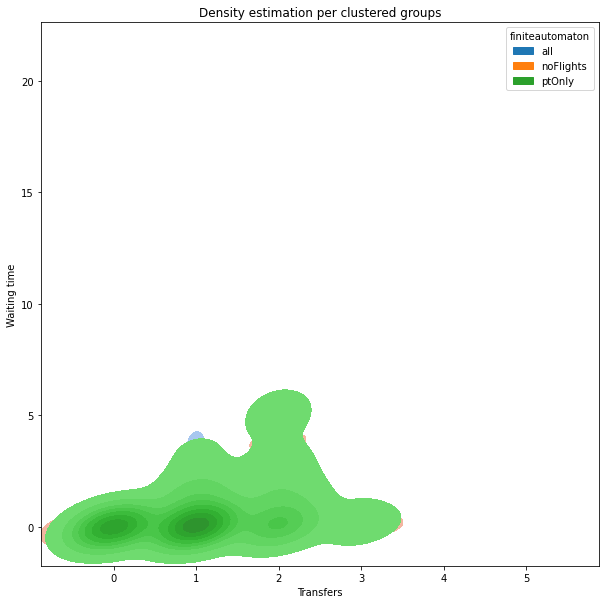

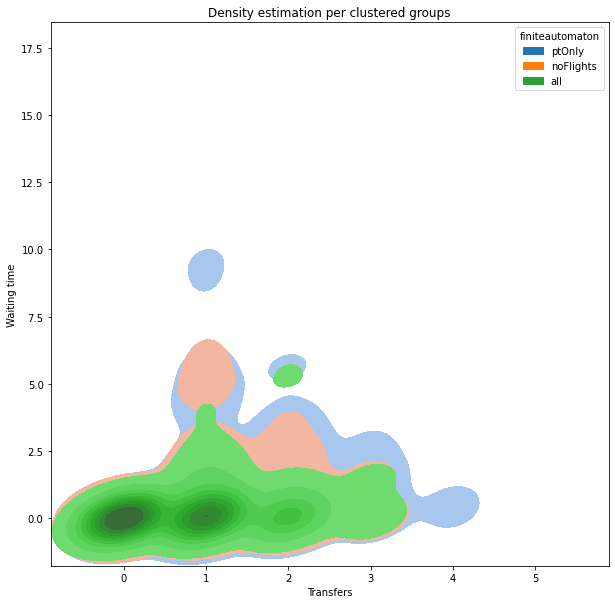

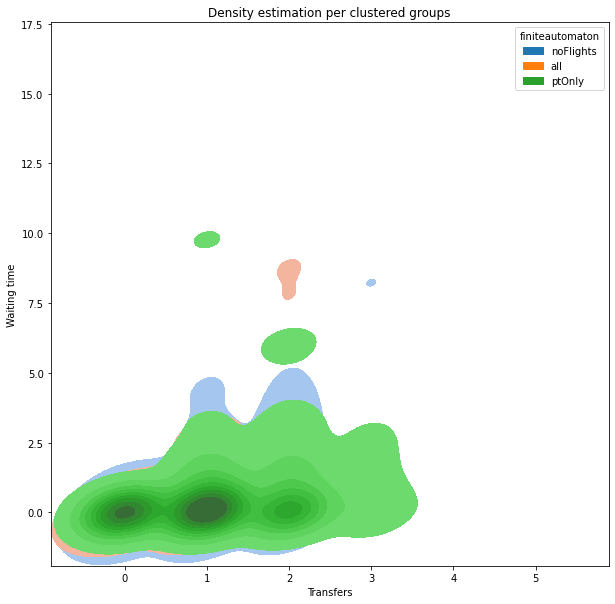

In [ ]:
#plotting the groups per density plots
def plot1(data):
  plt.figure(figsize=(10,10))#check the size
  sns.kdeplot(x=data.totalnumberofchanges,y=data.totalwaitingtime,hue=data.finiteautomaton,shade=True)
  plt.title('Density estimation per clustered groups')
  plt.xlabel('Transfers')
  plt.ylabel("Waiting time")

plot1(cluster_1)
plot1(cluster_2)
plot1(cluster_3)
plot1(cluster_4)
plot1(cluster_5)
plot1(cluster_6)


Conclusion-after dbscan got the groups per mode of transportation, all groups PT only except 5th and 6th, ptonly fo the groups-more transfers=more waiting time

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



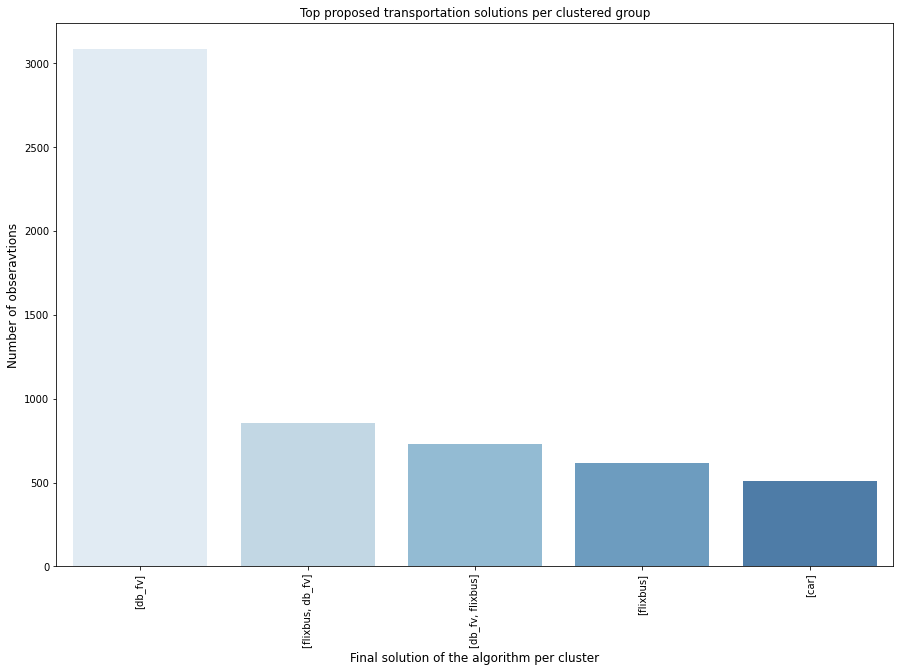

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



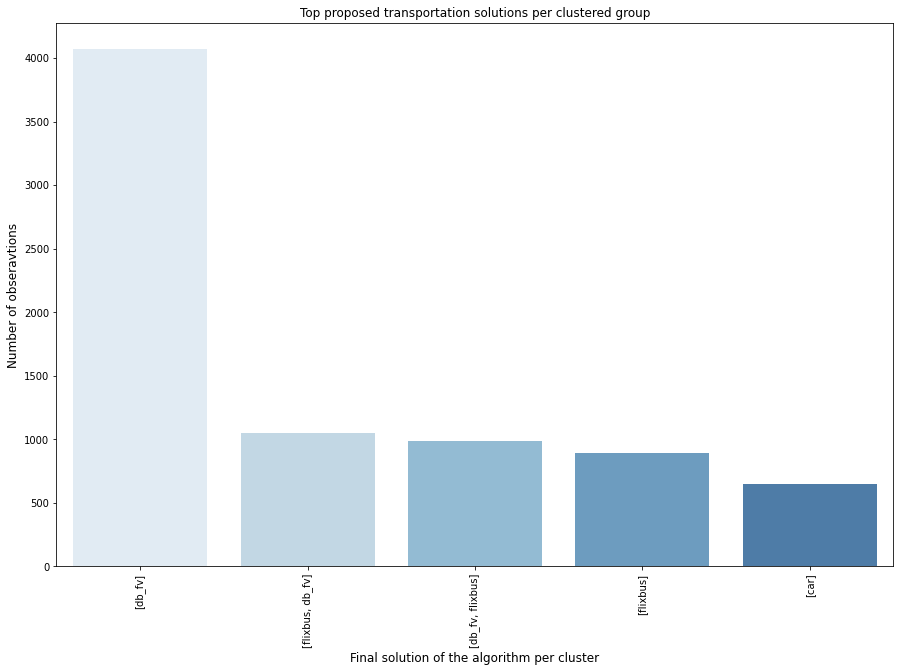

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



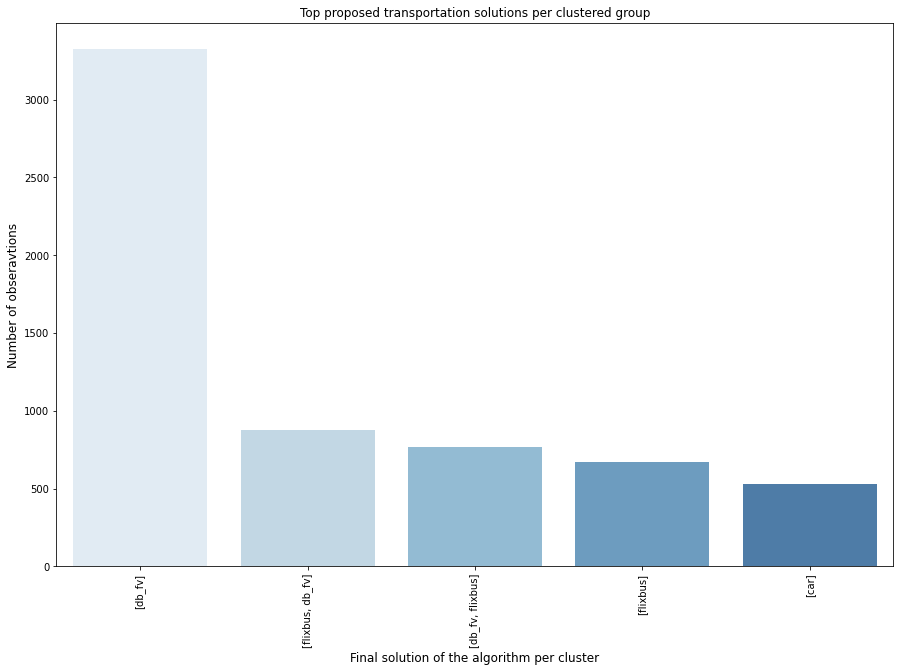

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



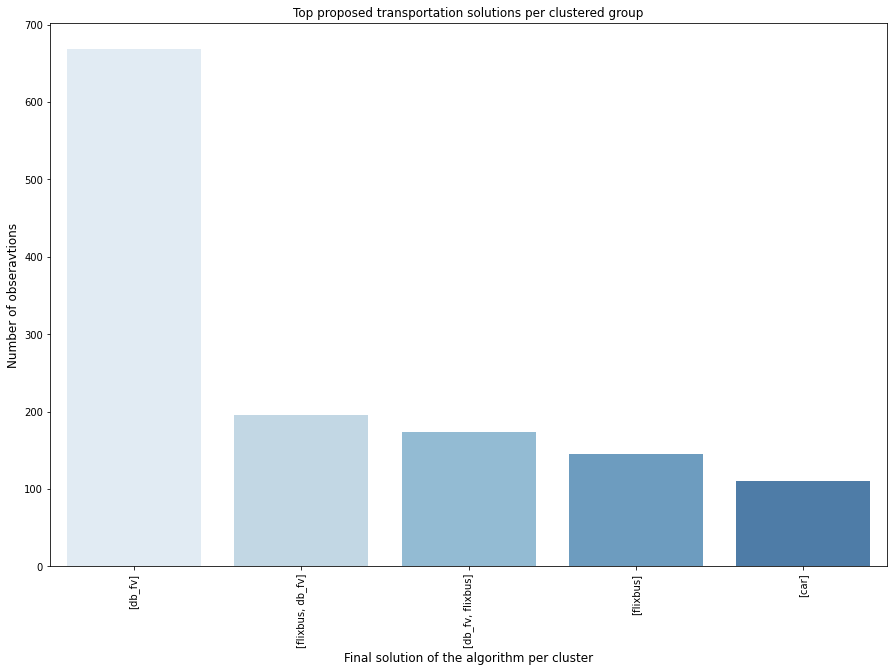

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



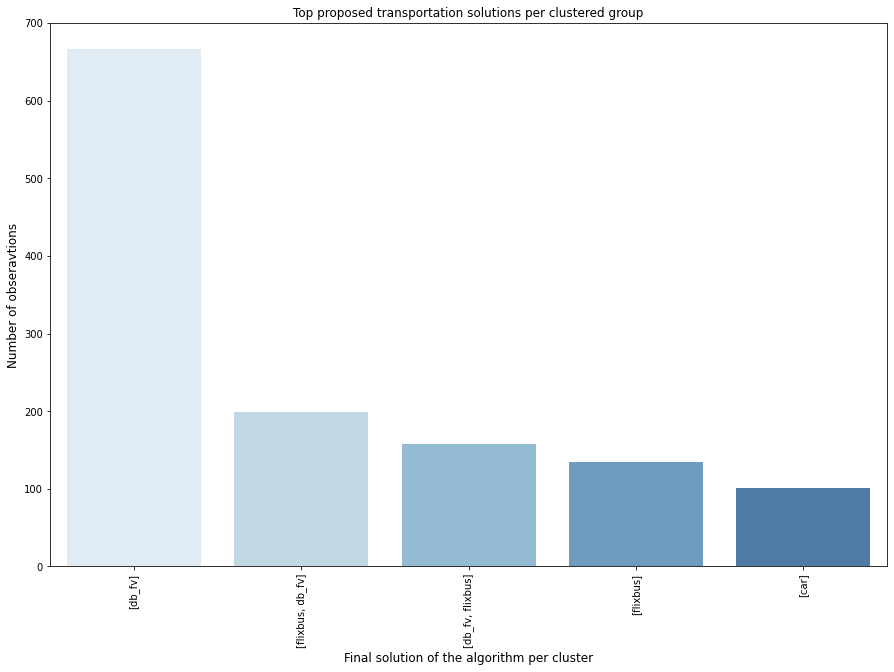

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



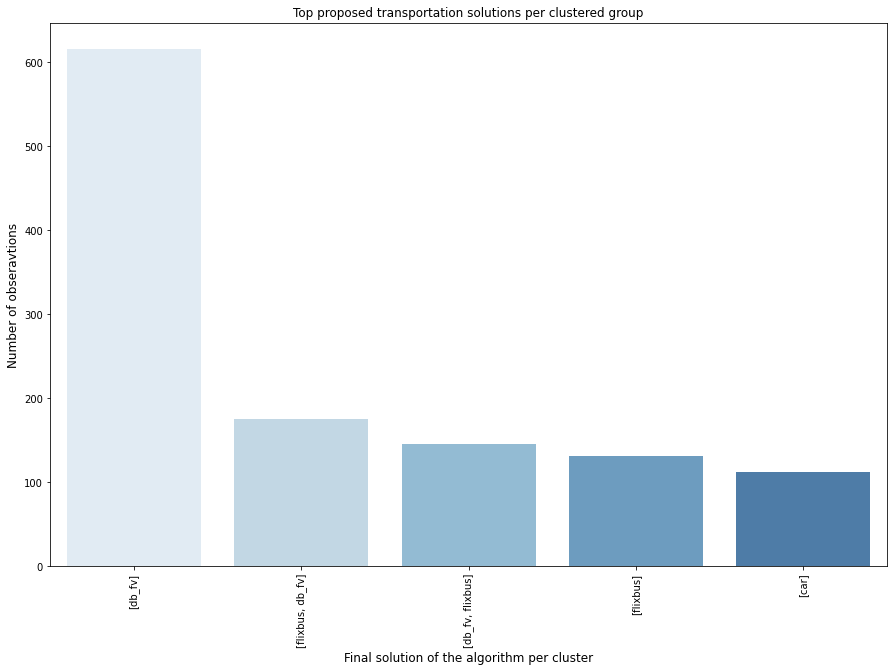

In [ ]:
def plot2(data):
# top proposed solutions
  cnt_srs = data['finalsolutionusedlabels'].value_counts().nlargest(5)
  plt.figure(figsize=(15,10))
  sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette="Blues")
  plt.title('Top proposed transportation solutions per clustered group')
  plt.xticks(rotation='vertical')
  plt.xlabel('Final solution of the algorithm per cluster', fontsize=12)
  plt.ylabel('Number of obseravtions', fontsize=12)
  plt.show()

plot2(cluster_1)
plot2(cluster_2)
plot2(cluster_3)
plot2(cluster_4)
plot2(cluster_5)
plot2(cluster_6)

#all groups-the train is mostly involved, then always flixbus
#we do not have distinct groups

Normally for all groups-the train is mostly involved, then always flixbus, we do not have distinct groups per label

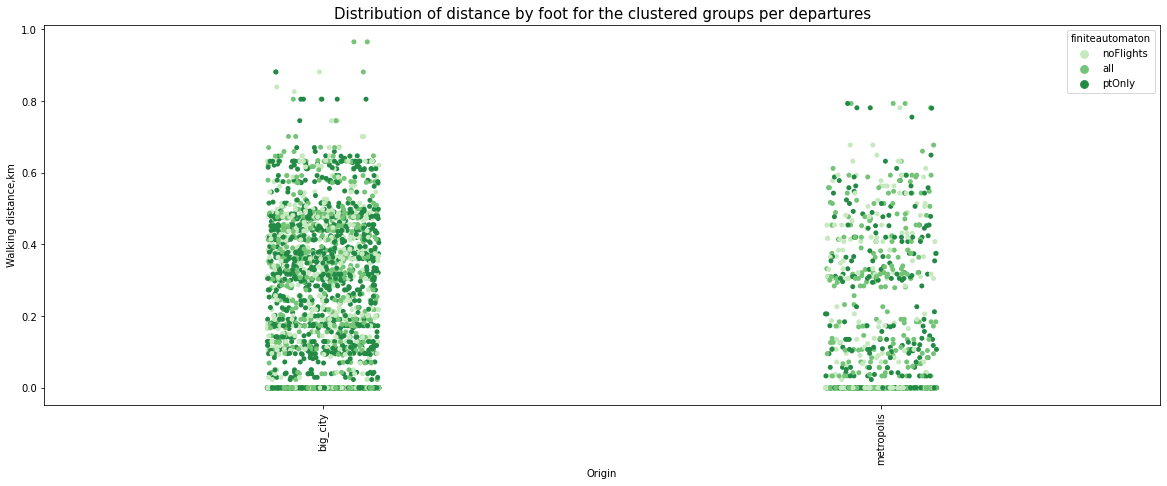

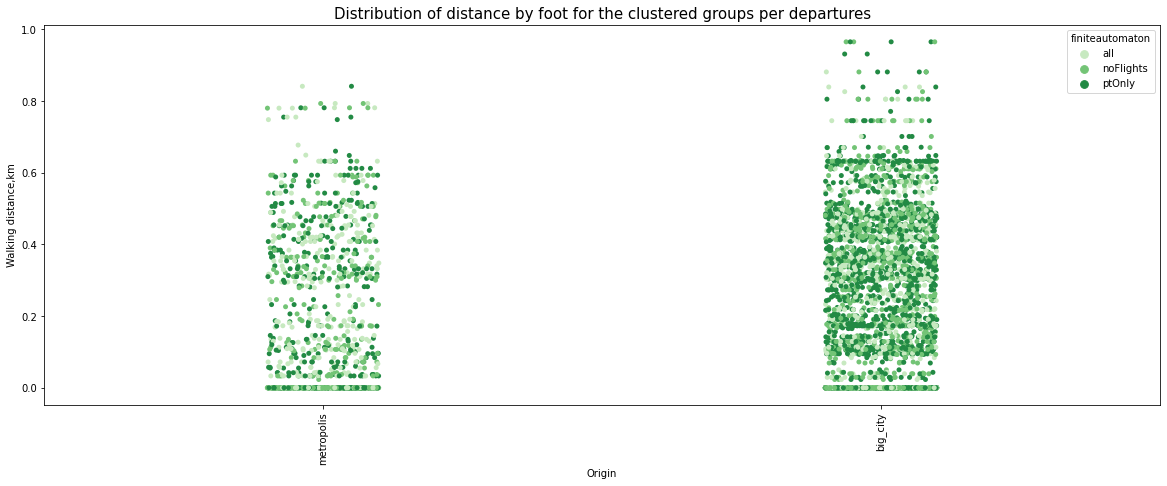

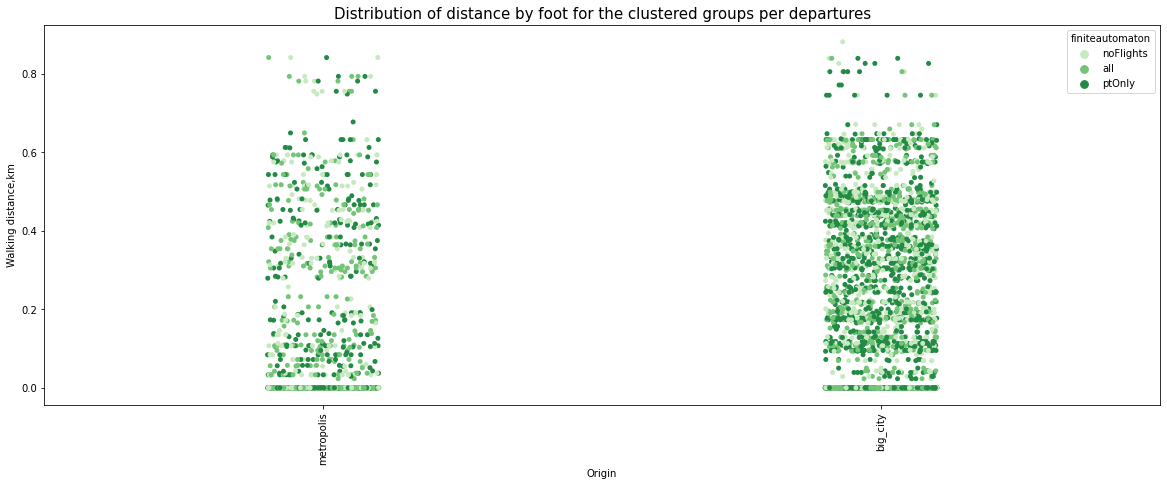

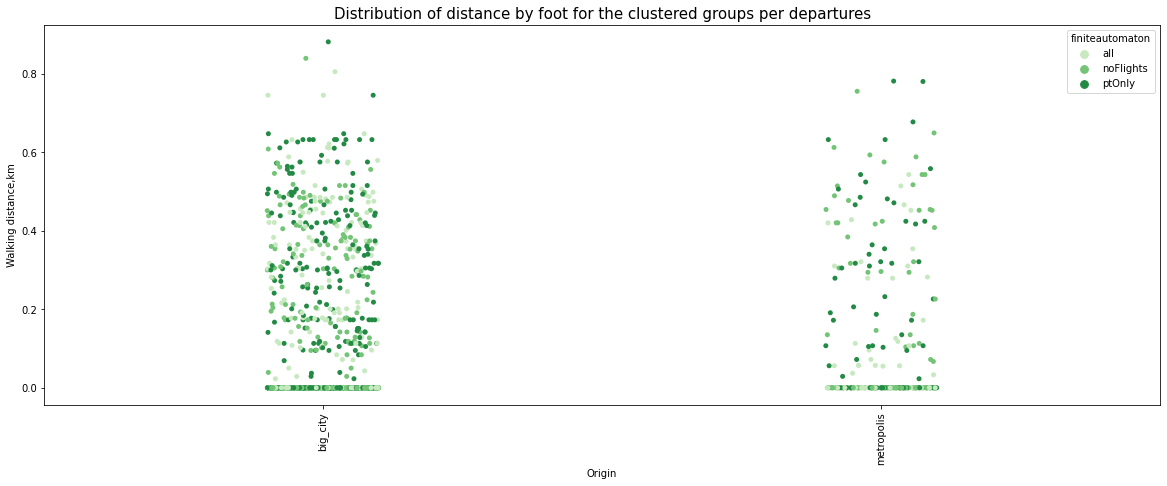

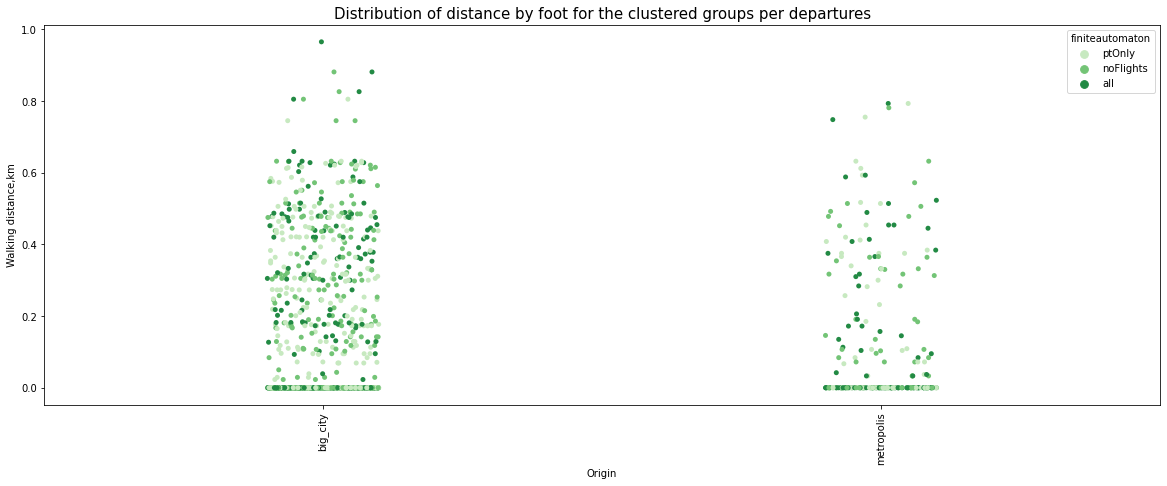

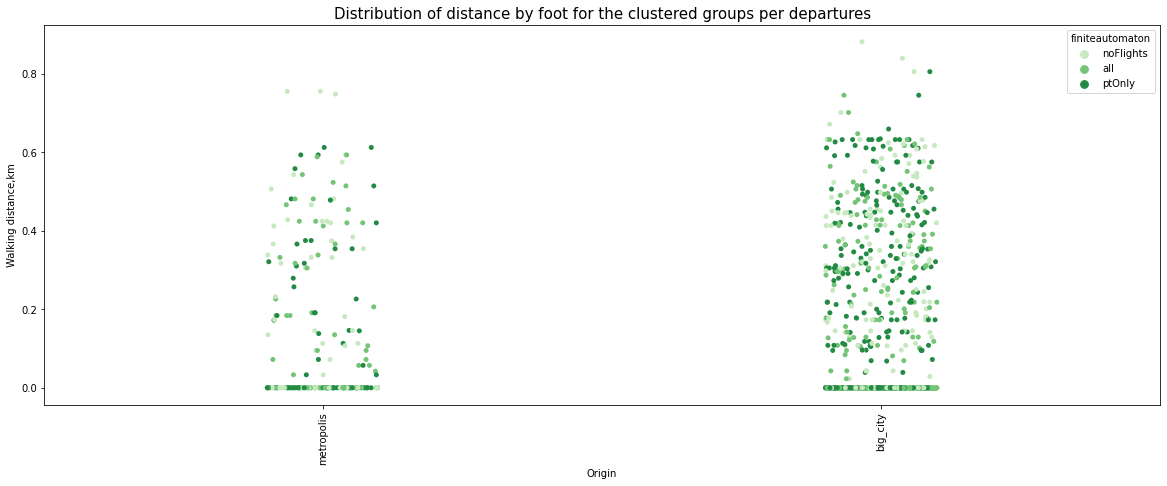

In [ ]:
#check the walking distance pattern per cities from where to travel

def plot3(data):
  plt.figure(figsize=(20, 7))

  sns.stripplot(x=data['travelfrom'],y=data['totalwalkingdistance'],hue=data['finiteautomaton'],palette='Greens')#configure the axis
  plt.xlabel("Origin", size = 10)
  plt.xticks(rotation='vertical')
  plt.ylabel("Walking distance,km", size = 10)
  plt.title('Distribution of distance by foot for the clustered groups per departures',fontsize=15)

plot3(cluster_1)
plot3(cluster_2)
plot3(cluster_3)
plot3(cluster_4)
plot3(cluster_5)
plot3(cluster_6)


1st, 2d and 3d groups ar the most dense to travelfrom bigcity with public transport and all mode

Beieve that 6 groups are too many to find the distinct patterns, should be less groups as we had for kprototypes (4)-easier to find the nice and discriptive differences

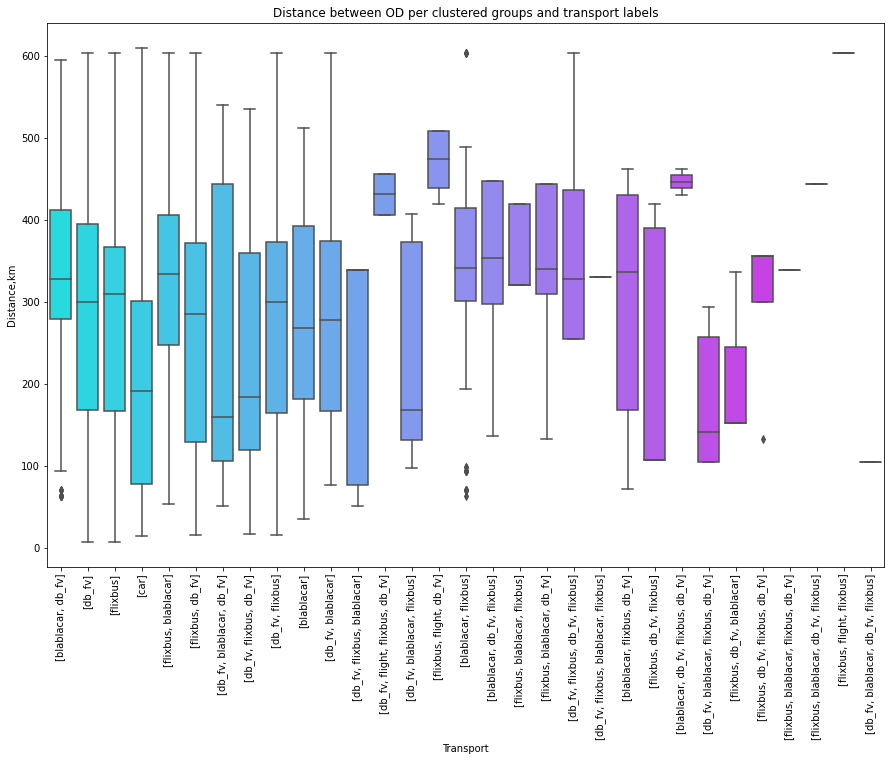

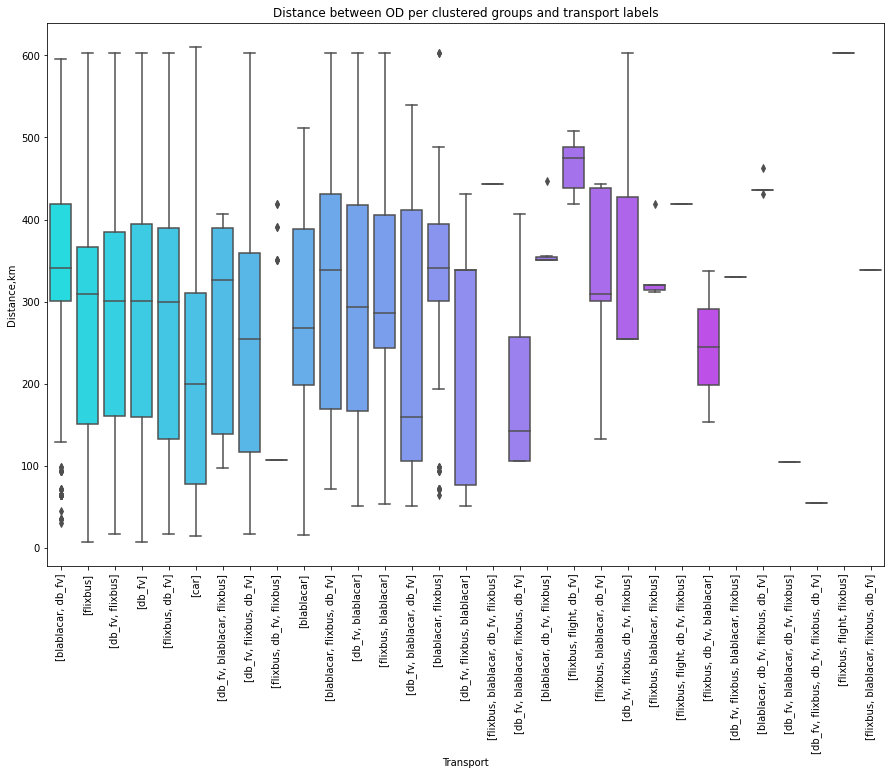

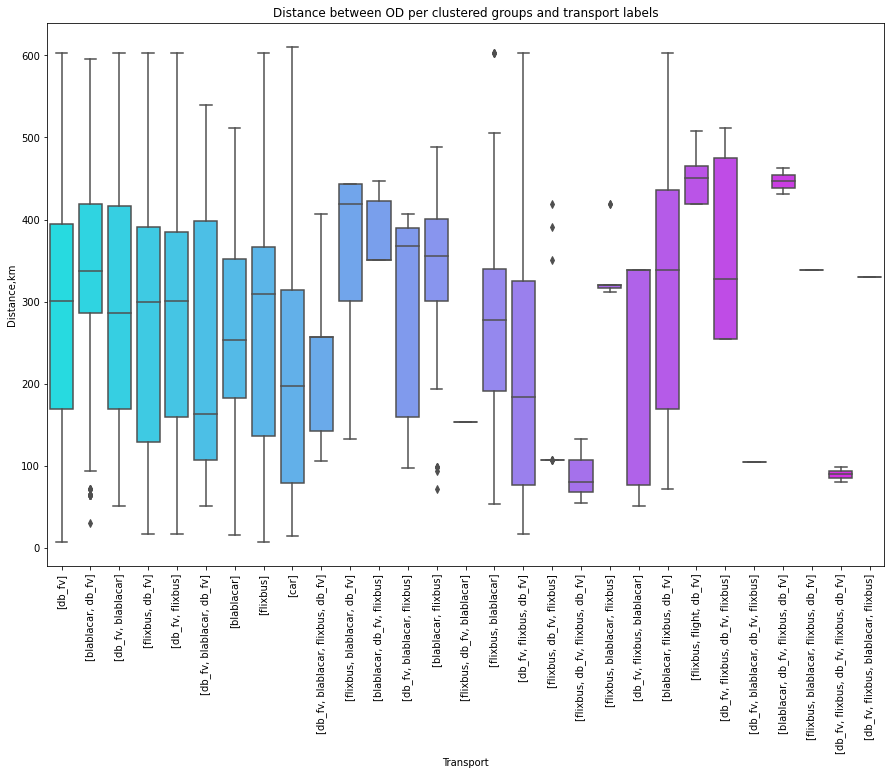

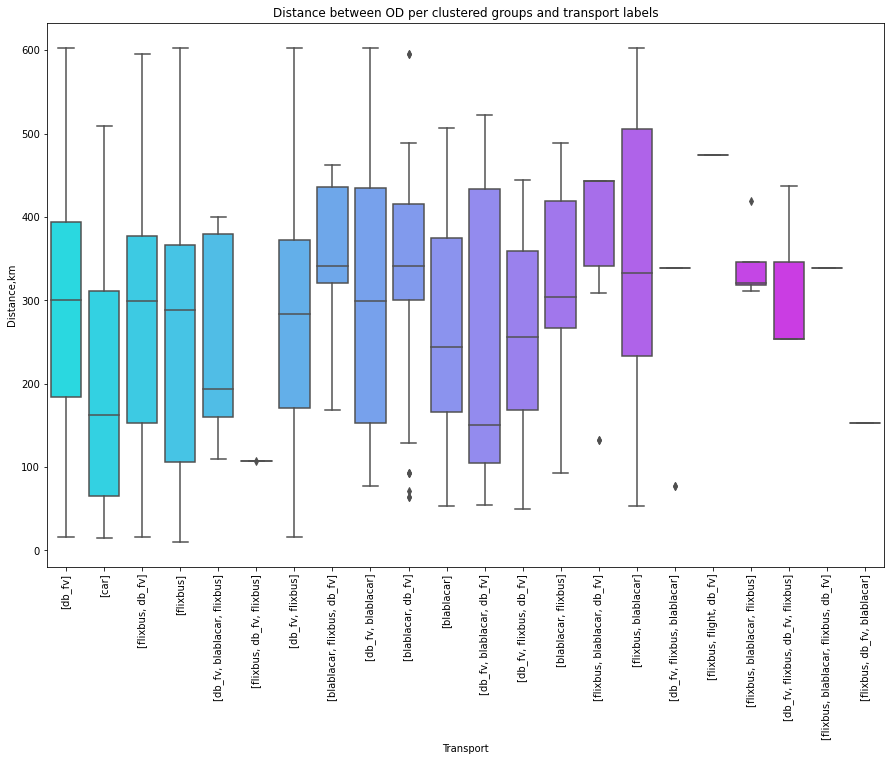

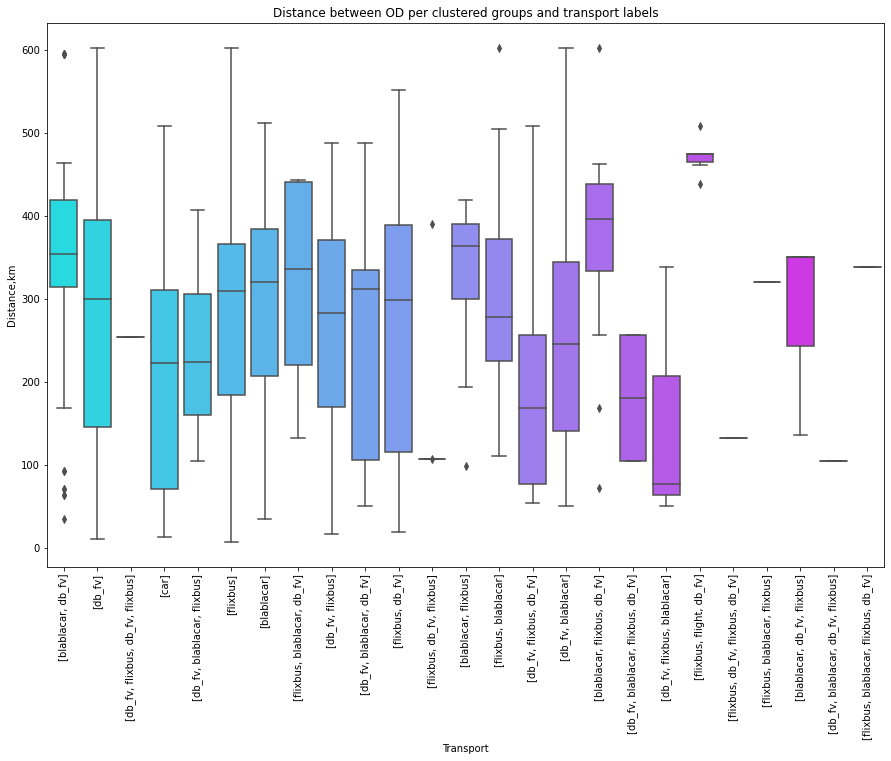

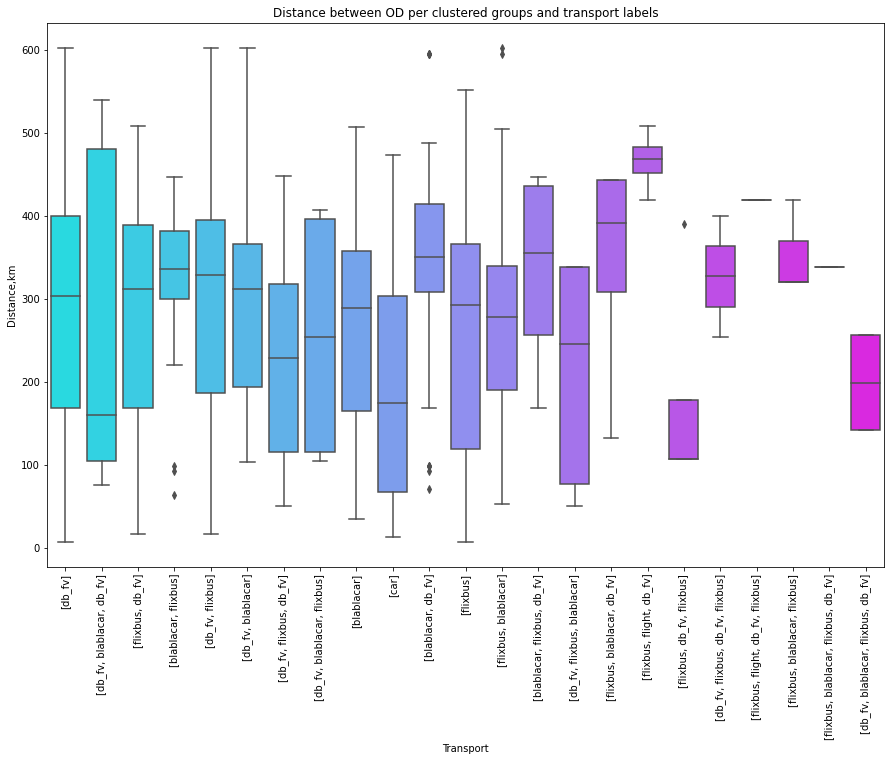

In [ ]:
#plot the data to reveal the mode types involved per distance incorporated

def plot4(datt):
  plt.figure(figsize=(15, 10))
  sns.boxplot(data=datt,x="finalsolutionusedlabels", y='distance',palette='cool')#take care about variables of the data
  plt.title('Distance between OD per clustered groups and transport labels')
  plt.xticks(rotation='vertical')
  plt.xlabel('Transport')
  plt.ylabel("Distance,km")


plot4(cluster_1)
plot4(cluster_2)
plot4(cluster_3)
plot4(cluster_4)
plot4(cluster_5)
plot4(cluster_6)


Groups are equal -no distinct pattern with the dissimilarities,

The groups include almost all the transport modes inside:31 for 1st and 2s (from 33 possible), 29 for the third, 22,25 and 23 for the rest ones-mix of labels

Are not easily distinguishable with respect to distances and labels